# 1. Variational Quantum Eigensolver

Due to the new updates every few months in this subject, the code has to be run with specific package versions, in order to avoid incompatibility. 

In [1]:
# !pip install matplotlib==3.10.6 pennylane==0.37.0 pyscf==2.10.0 pylatexenc==2.10 ipykernel==6.30.1 qiskit-ibm-runtime==0.43.1 qiskit-aer==0.17.2 qiskit-nature==0.7.2 scikit-learn==1.7.2 qiskit-ibm-catalog==0.11.0 qiskit-serverless==0.27.1 qiskit-optimization pymatgen CoRE_MOF

## 1.1 Theoretical background

We start our VQE project with a simple tast. We wish to determine the lowest eigenvalue of the  matrix U.

$$
U = 
\begin{bmatrix}
1.5 & 0 & 0 & 3.5 \\
0 & 2.5 & -1.5 & 0 \\
0 & -1.5 & 2.5 & 0 \\
3.5 & 0 & 0 & 1.5
\end{bmatrix}
$$

This will be done with VQE-like circuits. To achieve this, we need to express the $U$ as a combination of Pauli operators ${\mathbb{1}, X, Y, Z}$.

$$
\mathbb{1} =
\begin{bmatrix}
1 & 0  \\
0 & 1
\end{bmatrix}\quad
X =
\begin{bmatrix}
0 & 1 \\
1& 0
\end{bmatrix}\quad
Y =
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\quad
Z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$


This decomposition is required to implement $U$ on a quantum computer. Since we are working with a $4\times4$ matrix, two qubits are needed, so the target decomposition consists of tensor products of two Pauli operators (for example $X_1 \otimes Y_2$, where the subscript specifies the qubit on which the operator acts).


### Decomposition in terms of Pauli operators

Since

$$
X_1\otimes X_2 = 
\begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} =
\begin{bmatrix} 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix}\\ 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Y_1\otimes Y_2 = 
\begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ -1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Z_1\otimes Z_2 = 
\begin{bmatrix} 1 & 0\\ 0 & -1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 0\\ 0 & -1 \end{bmatrix} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

$$
\mathbb{1}_{4\times4} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

We can see that: 

$$
U = \frac{1}{2}\big(4\,I_1\otimes I_2\big) + \frac{1}{2}\big(2\,X_1 \otimes X_2\big) - \frac{1}{2}\big(5\,Y_1\otimes Y_2\big) - \frac{1}{2}\big(Z_1\otimes Z_2\big)
$$

In other words, this gives the required decomposition of the matrix $U$ in terms of Pauli operators. In VQE algorithms, it's practical to work by minimizing the energy of a system, so from this point on the matrix will be referred to as the Hamiltonian $\mathcal{H} = U$ of the system, and the energy as its expectation value on a given state $|\psi(\theta)\rangle$, namely $E(\theta) = \langle \mathcal{H} \rangle_{\theta} = \langle \psi(\theta) | \mathcal{H} | \psi(\theta)\rangle$.

Aditionally, if $|\psi(\theta)\rangle$ is an eigenvector of the $\mathcal{H}$, its energy $E(\theta)$ coincides with the corresponding eigenvalue. The objective is therefore to determine the lowest eigenvalue of $\mathcal{H}$ by minimizing $\langle \mathcal{H} \rangle \rightarrow \langle \mathcal{H} \rangle_{|\psi(\theta_{min})\rangle}$. The challenging aspect is to choose a trial state that admits a good parametrization (there is no guarantee that, by varying $\theta$, the eigenvector associated with the smallest eigenvalue can actually be reached).

### Variational Quantum Eigensolver

The core idea of VQE is to use a quantum computer to evaluate the expectation value of the Hamiltonian on a trial state $|\psi(\theta_1,\theta_2)\rangle$ parameterized by the real parameters $\theta_1$ and $\theta_2$, and then gradually vary these parameters in order to obtain smaller and smaller values of the energy $E(\theta_1,\theta_2)$.

Since $\langle I_1 \otimes I_2 \rangle = 1$ (we ommit now $\otimes$ for readability) :

$$
\langle \mathcal{H} \rangle 
= \frac{1}{2}\big(4\cdot 1 + 2\langle X_1 X_2\rangle - 5\langle Y_1 Y_2\rangle - \langle Z_1 Z_2\rangle\big)
$$  

This implies that suitable quantum circuits must be used to estimate the expected values of the operators $X_1 X_2,\ Y_1 Y_2,\ Z_1 Z_2$, and then these contributions are combined to recover the eigenvalue $E = \langle \mathcal{H} \rangle$.

On current quantum devices, measurements are typically performed in the $Z$ basis (the computational basis), which means that we directly access eigenvectors and eigenvalues of $Z$. To measure different observables, a basis change is required, implemented by adding appropriate gates just before the measurement.

For

With:
$$
X=HZH\quad Y=(HS^\dagger)^\dagger Z(HS^\dagger)
$$
it is possible to measure in the $X$ basis by inserting a Hadamard gate $H$ before the measurement. An analogous procedure holds for $Y$, using the combination of Hadamard and phase gates $HS^\dagger$.

In our setting, however, the goal is to measure two-qubit observables.

#### Observable $Z_1 Z_2$
  
The operator $Z_1 Z_2$ acts as follows: 
$$
Z_1 Z_2|00\rangle = +1 |00\rangle \quad\\
Z_1 Z_2|11\rangle = +1 |11\rangle \quad\\
Z_1 Z_2|01\rangle = -1 |01\rangle \quad\\
Z_1 Z_2|10\rangle = -1 |10\rangle \quad\\
$$
In other words, it checks whether the two qubits are in the same state (both $0$ or both $1$), in which case the eigenvalue is $1$, and if they are different the eigenvalue is $-1$. A similar behaviour can be reproduced using a CNOT gate, since this gate writes on the second qubit the binary sum of the two inputs, $\text{CNOT}|q_1\rangle|q_2\rangle = |q_1\rangle|q_1 \oplus q_2\rangle$.
It is important to note that the numerical outcomes (eigenvalues) coincide, but the final states obtained via the CNOT differ from those produced directly by $Z_1 Z_2$.
Indeed, if
* $q_1 = q_2$ (the two qubits are equal), then $|q_1 \oplus q_2\rangle = |0\rangle$ and measuring the second qubit in the computational ($Z$) basis yields the result $+1$,
* $q_1 \neq q_2$, then $|q_1 \oplus q_2\rangle = |1\rangle$ and a measurement yields $-1$, as required.

> Recall that for a general qubit $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$, one has $\langle Z \rangle = \langle \psi | Z | \psi \rangle = |\alpha|^2 - |\beta|^2$.

Thus, the observable $Z_1 Z_2$ can be accessed by inserting a CNOT gate and then measuring only the second qubit in the standard $Z$ basis. Measuring whether this qubit is in state $|0\rangle$ or $|1\rangle$ gives a direct bijection with the possible outcomes of $Z_1 Z_2$, namely $+1$ or $-1$, respectively. The corresponding circuit is shown below. From now on, we will use the optimized Qiskit python library, at first only to simulate circuit sampling.

Measurement in the ZZ basis


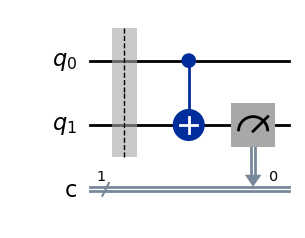

In [32]:
from qiskit import QuantumCircuit, QuantumRegister,  ClassicalRegister, transpile

circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.cx(0,1)
circuit.measure(1,0) #qubit 1 to cbit 0
print("Measurement in the ZZ basis")
circuit.draw(output="mpl")

Other two-qubit observables can be reduced to a measurement of $Z_1 Z_2$ by applying suitable unitary transformations (i.e., performing an appropriate change of basis).

#### Observable $X_1 X_2$

Using the relation $X = H Z H$ together with the CNOT-based measurement of $Z_1 Z_2$, the observable $X_1 X_2$ can be measured by employing the following circuit:

Measurement in the XX basis


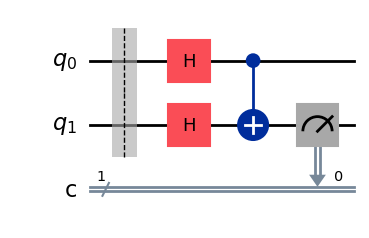

In [33]:
circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.h(0)
circuit.h(1)
circuit.cx(0,1)
circuit.measure(1,0)
print("Measurement in the XX basis")
circuit.draw(output="mpl")

#### Observable $Y_1 Y_2$

Using the identity $Y = (HS^\dagger)^\dagger Z (HS^\dagger)$ together with the CNOT-based measurement of $Z_1 Z_2$, the observable $Y_1 Y_2$ can be measured by means of the following circuit:

Measurement in the YY basis


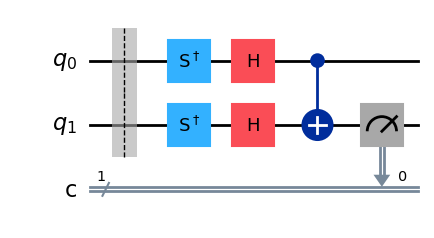

In [34]:
circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.sdg(0)
circuit.sdg(1)
circuit.h(0)
circuit.h(1)
circuit.cx(0,1)
circuit.measure(1,0)
print("Measurement in the YY basis")
circuit.draw(output="mpl")

## 1.2 VQE Implementation 

The next step is to implement the VQE architecture, which operates as follows:
* select an ansatz for a trial state $|\psi(\theta)\rangle$, parameterized by a real parameter $\theta$
* employ several quantum circuits to estimate the expectation values $\langle X_1 X_2 \rangle_\theta$, $\langle Y_1 Y_2 \rangle_\theta$ and $\langle Z_1 Z_2 \rangle_\theta$ on the same underlying trial state, where the subscript emphasizes the dependence on $\theta$ 
* evaluate the energy $E(\theta) = \langle \mathcal{H} \rangle_\theta$
* update $\theta$ so as to obtain a smaller energy



Following this prescription we chose an ansatz trial circuit. It has to be simple in order to accelerate calculation, but has to include some kind of entanglement. This is achieved by two different Y rotations, and a CNOT gate between the qubits.
$$|\psi(\theta_1, \theta_2)\rangle=
\big[\text{CNOT}_{1,2}\,(R_Y(\theta_1)_1 \otimes R_Y(\theta_2)_2)\big]\,|00\rangle$$




Ansatz initial state, with thetas: 1.3, 0.6


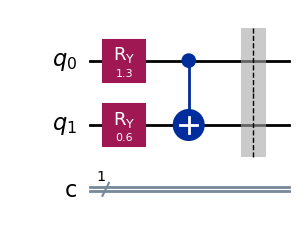

In [35]:
#simple ansatz entangled circuit
circuit = QuantumCircuit(2, 1)

theta0 = 1.3
theta1 = 0.6

#rotations setting the initial state
circuit.ry(theta0, 0)
circuit.ry(theta1, 1)
circuit.cx(0,1)

circuit.barrier()
print(f"Ansatz initial state, with thetas: {theta0}, {theta1}")
circuit.draw(output="mpl")

###### Importation of packages

In [36]:
import qiskit_aer
from scipy.optimize import minimize_scalar, minimize
from numpy import pi

sim_bknd = qiskit_aer.Aer.get_backend('qasm_simulator')

###### Functions declaration

In [37]:
def ansatz(circuit, qr, params):
    #Ansatz uses 2 angles to control qubits independently before entanglement
    #params: list of floats, e.g., [theta_0, theta_1]
    
    theta0 = params[0]
    theta1= params[1]
    # independent rotations
    circuit.ry(theta0, qr[0])
    circuit.ry(theta1, qr[1])
    
    circuit.cx(qr[0], qr[1])
    
    return circuit


def measurements(circuit, qr, cr, op):
    #Applies rotations to measure in XX, YY, or ZZ bases
    
    if op == "XX":
        # with X=HZH
        circuit.h(qr[0])
        circuit.h(qr[1])
        
        # cnot to measure ZZ 
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])     
    
    elif op == "YY":
        # with Y = (H S�)Z(H S�)
        circuit.sdg(qr[0])
        circuit.sdg(qr[1])
        circuit.h(qr[0])
        circuit.h(qr[1])
        
        # cnot
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])
        
    elif op == "ZZ":
        # cnot
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])
    
    else:
        print(f"Measurement in the {op} base is not supported")
        return circuit
        
    return circuit


def hamiltonian(dic):
    #Evaluates the energy of the trial state using the mean values of XX, YY and ZZ.
    #params : Dictionary containing the expectation values of XX, YY and ZZ
    # Apply the Hamiltonian H = 1/2 * (Id + XX - YY - ZZ)
    energy = (4*1 + 2*dic['XX'] - 5*dic['YY']- dic['ZZ'] ) / 2
    return energy


def vqe_step(params, verbose=False):
    # vqe loop with 2 parameters
    times = 10000
    vqe_res = {}   # {'XX': val, 'YY': val, 'ZZ': val}
    circuit_list = {}   # {'XX': qc,  'YY': qc,  'ZZ': qc}

    # we need to run 3 separate circuits: one for XX, one for YY, one for ZZ
    for i in ["XX", "YY", "ZZ"]:
        qr = QuantumRegister(2, "qr")
        cr = ClassicalRegister(1, "cr")
        circuit = QuantumCircuit(qr, cr)

        # Ansatz with current params
        circuit = ansatz(circuit, qr, params)
        circuit.barrier()
        # measurement Gates
        circuit= measurements(circuit, qr, cr, i)
        # Transpile and Run
        circuit_t = transpile(circuit, sim_bknd)
        job = sim_bknd.run(circuit_t, shots=times)
        counts = job.result().get_counts()

        # counts['0'] is the ammount of zeros measured
        # counts['1'] is the ammount of ones
        
        # mean value of Z
        if len(counts) ==1:
            expectation_values = 1 if '0' in counts else -1
        else:
            # 0 in the classical bit means eigenvalue 1
            # 1 in the classical bit means eigenvalue -1
            expectation_values = (counts['0'] - counts['1']) / times      # values for XX YY et ZZ
        vqe_res[i] = expectation_values
        circuit_list[i] = circuit

    # Energy
    energy = hamiltonian(vqe_res)
    
    if verbose:
        print("Mean values from measurement results:\n", vqe_res)
        print()
        print(f"{'Theta 0':>12} {'Theta 1':>12} {'Energy':>12} {'<XX>':>12} {'<YY>':>12} {'<ZZ>':>12}")
        print(f"{params[0]:>12.6f} {params[1]:>12.6f} {energy:>12.6f} "
                f"{vqe_res['XX']:>12.6f} {vqe_res['YY']:>12.6f} {vqe_res['ZZ']:>12.6f}")
        return energy, circuit_list

    return energy

Let us now verify that the whole procedure works correctly.

Mean values from measurement results:
 {'XX': -0.8414, 'YY': -0.6646, 'ZZ': -0.7916}

     Theta 0      Theta 1       Energy         <XX>         <YY>         <ZZ>
   -1.000000     2.500000     3.215900    -0.841400    -0.664600    -0.791600

 Example of the quantum circuit for the measurement of YY


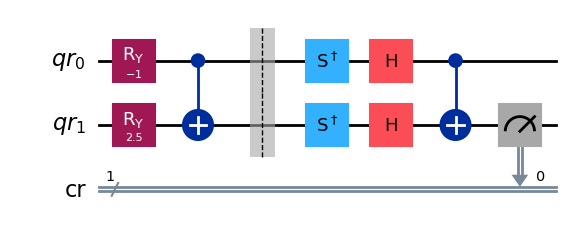

In [38]:
# value of theta
theta = [-1,2.5]
energy, circuit_list = vqe_step(theta, verbose = True)
# Plot for the measurement of YY
op_example = 'YY'
print(f"\n Example of the quantum circuit for the measurement of {op_example}")
circuit_list[op_example].draw(output="mpl")

We see that for the parameters $\theta_0 = -1.0$ and $\theta_1 = 2.5$, the energy $E(\theta_0,\theta_1) = \langle \mathcal{H} \rangle_{\theta_0,\theta_1} \approx 3.243$.

Our aim is to find a value for the parameter that gives the lowest possible energy, and that is the desired lowest eigenvalue.  
The minimization procedure can be done by hand, or by setting up an optimizer. 

##### Using an optimizer

In [39]:
# guess for theta
initial_theta = [0.0, 0.0]

print("Starting VQE Optimization...")
res = minimize(
    vqe_step, 
    initial_theta, method='COBYLA', options={'maxiter': 100})
print(res)

print("\nOptimization Complete!")
print(f"Optimal Angles: {res.x}")
print(f"Minimum Energy: {res.fun:.4f}") 

Starting VQE Optimization...
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.9965
       x: [-1.519e+00  3.866e-02]
    nfev: 31
   maxcv: 0.0

Optimization Complete!
Optimal Angles: [-1.51871447  0.03865918]
Minimum Energy: -1.9965


##### Conclusion
The optimizer successfully converges to a solution. More precisely, it identifies optimal values around $\theta_0 \approx -1.6$ and $\theta_1 \approx 0.0$, for which the corresponding energy is $E(\theta) \approx -1.998$.
We will now verify this result by passing these values to the vqe_step function.

In [40]:
lowest, circuit_list = vqe_step(res.x, verbose=True)
print(lowest)

Mean values from measurement results:
 {'XX': -0.9984, 'YY': 0.9978, 'ZZ': 0.9994}

     Theta 0      Theta 1       Energy         <XX>         <YY>         <ZZ>
   -1.518714     0.038659    -1.992600    -0.998400     0.997800     0.999400
-1.9926


And we can directly confirm that the target result is obtained as:

$$
\langle \mathcal{H} \rangle_{\theta_1,\theta_2} 
= \frac{1}{2}\big(4 + 2\langle X X\rangle - 5\langle Y Y\rangle - \langle Z Z\rangle \big) \
\approx \frac{1}{2}\big(4 + 2(-1) - 5(1) - (1)\big) = -2
$$  

with $\langle XX \rangle \approx -1$, $\langle YY \rangle \approx 1$, $\langle ZZ \rangle \approx 1$.  

**Therefore, the Task is solved: the lowest eigenvalue of $\mathcal{H}$ (i.e., of $U$) is found to be $-2$.**

###### Final (classical) check
As a final step, the outcome of our calculation can be validated using SciPy�s eigensolver.

In [41]:
import numpy as np
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

# evaluation of two qubit Pauli matrices
II = np.kron(I, I)
XX = np.kron(X, X)
YY = np.kron(Y, Y)
ZZ = np.kron(Z, Z)
# hamiltonian
H = 0.5 * (4*II + 2*XX - 5*YY - ZZ)
print("Desired Hamiltonian H = \n", H)

Desired Hamiltonian H = 
 [[ 1.5+0.j  0. +0.j  0. +0.j  3.5+0.j]
 [ 0. +0.j  2.5+0.j -1.5+0.j  0. +0.j]
 [ 0. +0.j -1.5+0.j  2.5+0.j  0. +0.j]
 [ 3.5+0.j  0. +0.j  0. +0.j  1.5+0.j]]


This matrix coincides with $U$. We now proceed to compute its eigenvalues.

In [42]:
import scipy

#eigenvalues and eigenvectors of H
eigenvalues, eigenvectors = scipy.linalg.eig(H)
print("Eigenvalues:", eigenvalues)

Eigenvalues: [ 5.+0.j -2.+0.j  4.+0.j  1.+0.j]


$-2$ does appear as the smallest eigenvalue, in agreement with the value obtained using VQE.

In [ ]:
%reset -f   #we reset the jupyter kernel to delete previous variables

# 2. Variational Quantum Linear Solver

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister,  ClassicalRegister, transpile
from qiskit_aer import AerSimulator 
from qiskit_aer.primitives import EstimatorV2, SamplerV2

import math
import random
import numpy as np
from scipy.optimize import minimize

## 2.1 Introduction

The Variational Quantum Linear Solver (VQLS) is a variational quantum algorithm that utilizes VQE in order to solve a system of linear equations. We work in matrix form, where we are given some matrix $A$, such that $A |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$

$|\textbf{b}\rangle$ is some known vector which corresponds to the zeroth order coefficients. It can be modified to our will (by multiplying each corresponding equation by a certain amount). Finally VQLS algorithm is theoretically able to find a normalized $|\psi\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.



## 2.2 Theoretical analysis

To begin, the inputs into this algorithm are evidently the matrix $A$, which we have to decompose into a linear combination of unitaries with complex coefficients:



$$A \ = \ \displaystyle\sum_{n} c_n \ A_n,\quad A |\bold{x}\rangle = |\mathbf{b}\rangle,\quad |\mathbf{b}\rangle=U|0\rangle $$



Where each $A_n$ is a matrix created by quantum gates, and $U$ prepares state $|\textbf{b}\rangle$ from $|0 \rangle$. 
Now, recall the general structure of a variational quantum algorithm. We have to construct a quantum cost function that can be treated by a classical optimizer. This allows us to search a parameter space for some set of parameters $k$, such that $|\psi(k)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, where $|\psi(k)\rangle$ is the output of out quantum circuit corresponding to some parameter set $k$.



In our quantum circuit each qubit is initialized to $|0\rangle$. Our algorithm takes its inputs, then prepares and evaluates the cost function, starting with the creation of some ansatz $V(k)$. 

After this the algorithm is run again with different parameters in order to minimize the cost function. At the end, we get the optimized statevector parameters (to construct $|\psi \rangle$) and therefore the normalized form of $|\textbf{x}\rangle$.



Let's start off by considering the ansatz $V(k)$, which is just a circuit that prepares some arbitrary state $|\psi(k)\rangle$. This allows us to "search" the state space by varying some set of parameters, $k$. Applying different Control Z rotations mixed with Y rotations ( the parameters $k$ correspond to angles).\
The ansatz that we will use for this implementation is given as follows:

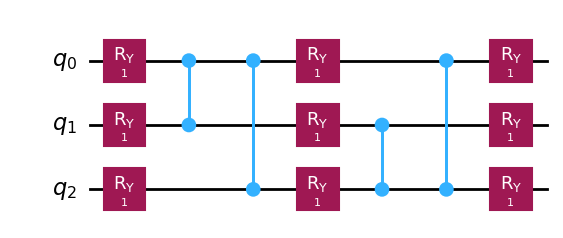

In [2]:
#creates the ansatz |psi_k> = V_k |0>         ('|0>' = |000>)

def apply_fixed_ansatz(circ,qubits, parameters):    

    for i in range (0, len(qubits)):
        circ.ry(parameters[0][i], qubits[i])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for i in range (0, len(qubits)):
        circ.ry(parameters[1][i], qubits[i])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for i in range (0, len(qubits)):
        circ.ry(parameters[2][i], qubits[i])

circ = QuantumCircuit(3)
apply_fixed_ansatz(circ,[0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

This is our fixed hardware ansatz: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. The applications of $R_y$ gates allow us to search the state space, while the $C_Z$ gates work as entanglement between the different qubit states. 
Unfortunately the use of $C_Z$ gates introduce sampling error, a general known problem in VQE.



Now we consider the cost function to be minimized. The goal is that when $|\Phi\rangle \ = \ A |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$ (a maximum in 1), we want our cost function's output to be very small. Conversely,  when the vectors are close to being orthogonal, we want the cost function to be very large. \
Thus, we consider a 'projection Hamiltonian':



$$H_P \ = \ \mathbb{I} \ - \ |\mathbf{b}\rangle \langle \mathbf{b}|$$



Then we find that the cost function $C_P$ is the expected value of the Hamiltonian:



$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |\mathbf{b}\rangle \langle \mathbf{b}|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle = {\langle \Phi | \Phi \rangle} - |{\langle \mathbf{b} | \Phi \rangle}|^2$$



The first term is the normalizing of the state being modified; but the relevant term is the second, as it tells us how much of $|\Phi\rangle$ lies along $|\mathbf{b}\rangle$. When the inner product of $|\Phi\rangle$ and $|\mathbf{b}\rangle$ is high (they agree more), we will get a low number. Indeed if $|\Phi\rangle$ = $|\mathbf{b}\rangle$ we get $C_P=0$

A last detail to take into account is the normalizing of the cost function. This is done because if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. This would give us fake minima, so we replace $|\Phi\rangle$ with $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$:



$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle \mathbf{b} | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$



Ok, so, we have prepared our state $|\psi(k)\rangle$ with the ansatz. Now, we have two values to calculate in order to evaluate the cost function,  $|\langle \mathbf{b} | \Phi \rangle|^2$ and $\langle \Phi | \Phi \rangle$.

The algorithm used is called a Hadamard test. In general if we have some unitary $U$ and some state $|\phi\rangle$, and we want to find the expectation value of $U$ with respect to the state, $\langle \phi | U | \phi \rangle$, then we can evaluate the following circuit:

<br><br>

![image1](images/h.png)

<br><br>

Then, the probability of measuring the first qubit to be $|0>$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and the probability of measuring $|1>$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two probabilities gives us $\text{Re} \langle U \rangle$. 

This algorithm suits us perfectly, as our matrices are real. So then $\text{Re} \langle U \rangle \ = \ \langle U \rangle$ in our case.



We implement this result with our vectors. 

Let's start with $\langle \Phi | \Phi \rangle$, where we have:

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$

The code below implements each term in the summation.



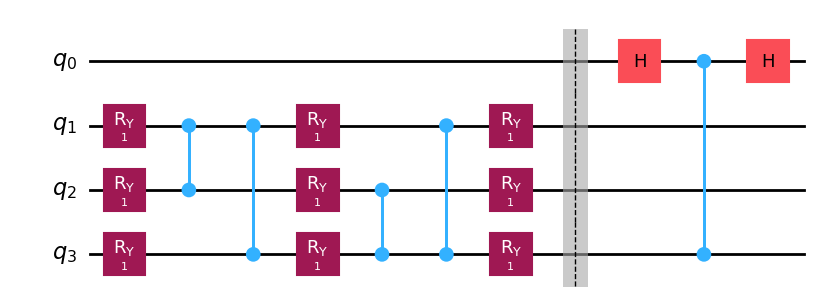

In [3]:
# Creates the Hadamard test to compute  <Phi|Phi> = <U>
def hadamard_test(circ,gate_type, qubits, auxiliary_index, parameters):
    apply_fixed_ansatz(circ,qubits, parameters)
    circ.barrier()
    circ.h(auxiliary_index)
    for i in range (0, len(gate_type[0])):
        if (gate_type[0][i] == 1):
            circ.cz(auxiliary_index, qubits[i])

    for i in range (0, len(gate_type[1])):
        if (gate_type[1][i] == 1):
            circ.cz(auxiliary_index, qubits[i])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
hadamard_test(circ,[[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

We are applying two different "gate_types" is because this represents the pairs of gates shown in the expanded form of $\langle \Phi | \Phi \rangle$.



Our problem matrices will be very simple, using only  $Z$ and $\mathbb{I}$ gates. We have then only number identifiers that will correspond to the application of the different gates, $0$ for $\mathbb{I}$ and $1$ for $Z$.



We calculate now the numerator in the cost function, which is $|\langle \mathbf{b} | \Phi \rangle|^2$. We get:

<br>



$$|\langle \mathbf{b} | \Phi \rangle|^2 \ = \ |\langle \mathbf{b} | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



All we have to do now is the same expansion as before 

$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

We know simplify by noting our real matrix elements, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$

So finally:



$$|\langle \mathbf{b} | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

We use again a Hadamard Test, but know due to the nature of the gates we need an extra auxiliary qubit to place a control on each of the gates involved in the unitary matrices computing. 



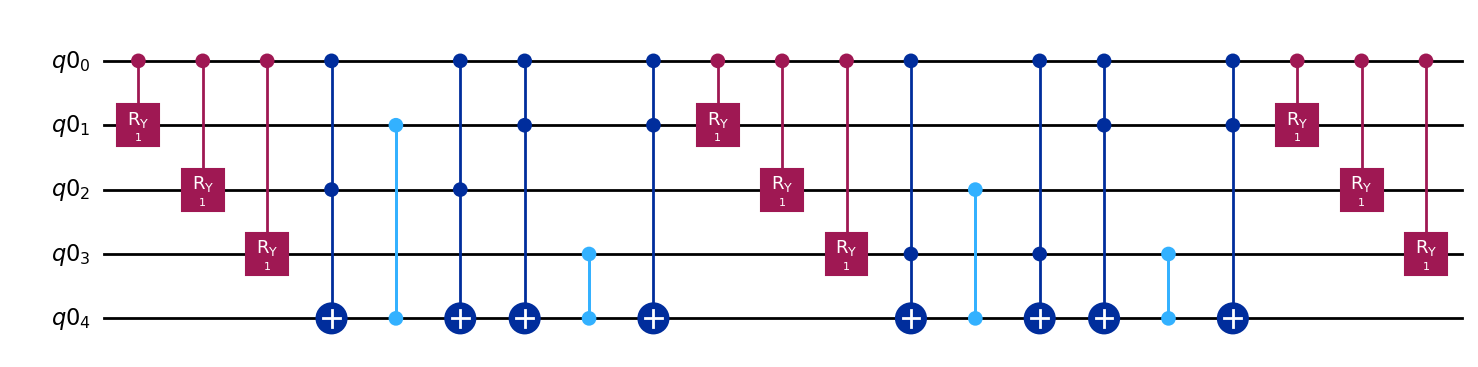

In [4]:
#creates controlled ansatz for calculating |<b|psi>|^2 with a Hadamard test
def control_fixed_ansatz(circ,qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz(circ,[1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw('mpl')

Now, we also have to create the circuit for $U$ (needed for the zeroth order coefficients vector). In our case it is simply:


$$U \ = \ H_1 H_2 H_3$$



<br>

Remember that $|b\rangle = U|0\rangle $ Thus, we have:

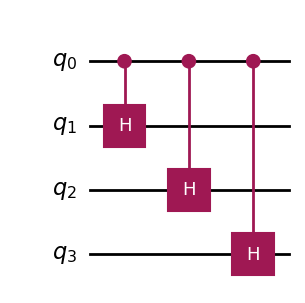

In [5]:
# for creating |b>

def control_b(circ,auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(circ,0, [1, 2, 3])
circ.draw('mpl')

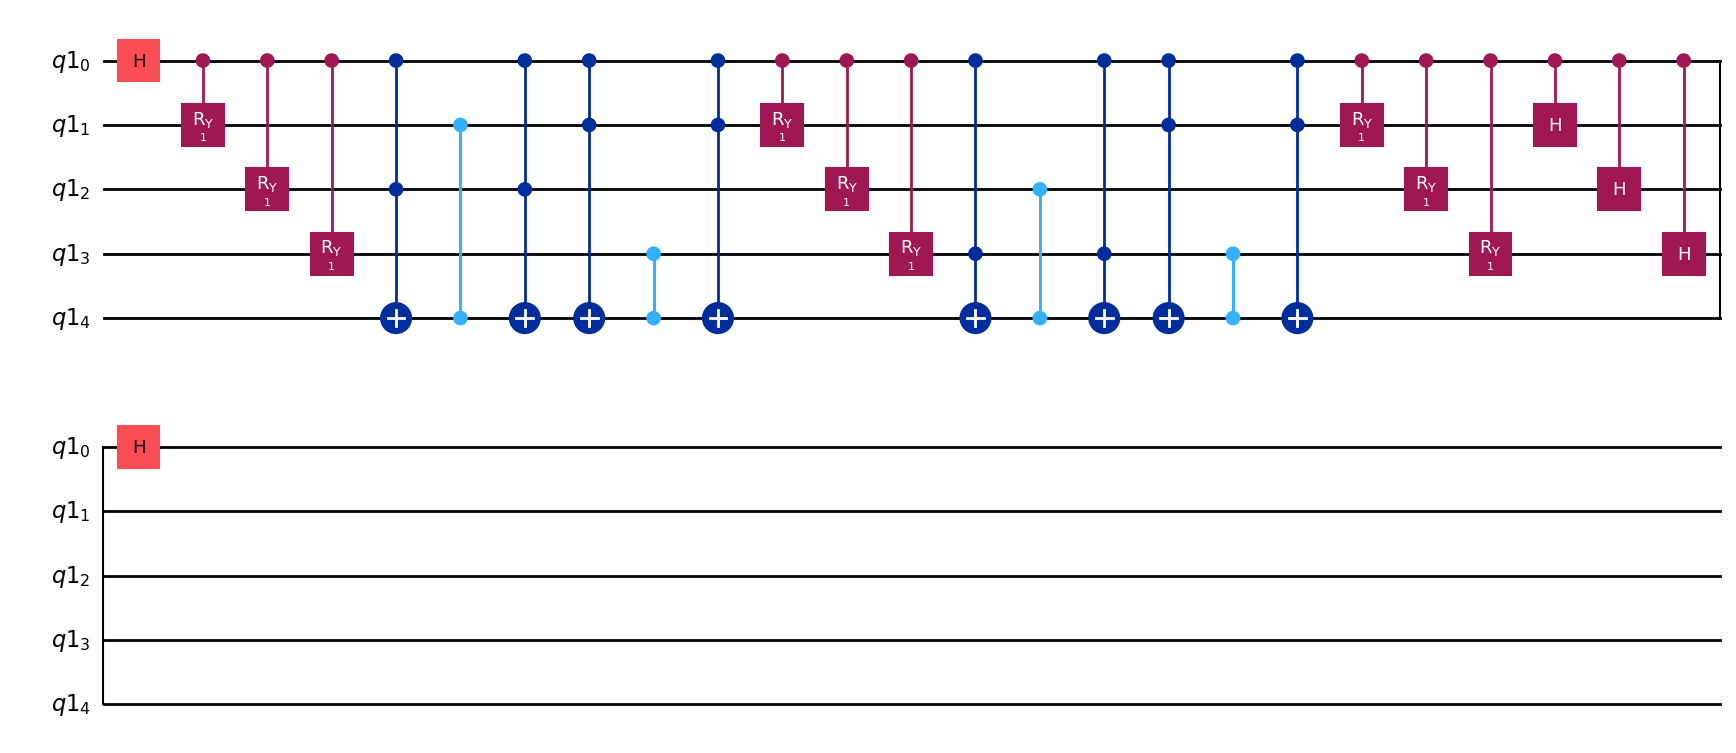

In [6]:
# Create the controlled Hadamard test, for calculating <b|psi>
def special_hadamard_test(circ,gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(circ,qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(circ,auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_hadamard_test(circ,[[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw('mpl')

The set of gates $A_n$ is simply `[0, 0, 0]` (identity on all gates), and `[0, 0, 1]` (Z on the third qubit).

Now, we are ready to calculate the final cost function.

## 2.3 Statevector simulations

In [7]:
# CALCULATE COST FUNCTION
import qiskit_aer
from qiskit_aer import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile

def calculate_cost_function(parameters, coefficient_set, gate_set):
    
    parameters = np.mod(parameters, 2*np.pi)
    # Restructure the 9 flat parameters into the 3 sets of 3 required by the ansatz
    ansatz_parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    backend = AerSimulator(method="statevector")
    
    
    # 1. CALCULATE DENOMINATOR: <phi|phi> = <psi|A^dagger A|psi>
    # Decomposition: <psi|A^dagger A|psi> = sum_i sum_j (a_i * a_j) * <psi|A_i^dagger A_j|psi>    
    denominator_sum = 0
    
    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):
            
            # The coefficient factor: a_i * a_j
            coeff_factor = coefficient_set[i] * coefficient_set[j]

            #initialize a new 5-qubit circuit for each pair (i, j)
            qctl = QuantumRegister(5, name='q')
            circ = QuantumCircuit(qctl)
            
            hadamard_test(circ, [gate_set[i], gate_set[j]], [1, 2, 3], 0, ansatz_parameters)

            # --- Simulation ---
            circ.save_statevector()
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ)
            result = job.result()
            
            # Get the final statevector
            final_statevector = result.get_statevector(circ)
            real_statevector = np.asarray(final_statevector).real

            # The Hadamard Test requires measuring the probability of the control
            # qubit (qubit 0) being 1. Since the state is |q4 q3 q2 q1 q0>, 
            #the states where q0=1 are the odd indices (index%2 == 1).
            prob_aux_is_one = 0

            for index, amplitude in enumerate(real_statevector):
                # Check if the least significant qubit (Qubit 0) is in state 1 (odd index)
                if (index % 2 == 1):
                    prob_aux_is_one += amplitude**2

            #calculate Overlap Term ---
            # The expectation value E = <Z_0> = 1 - 2*P(aux=1)
            inner_product_term = 1 - (2 * prob_aux_is_one)

            # Sum up the contributions to the denominator
            denominator_sum += coeff_factor * inner_product_term

    

    # 2. CALCULATE NUMERATOR: |<b|phi>|^2 = |<b|A|psi>|^2
    # Decomposition: |<b|A|psi>|^2 = |sum_i (a_i * <b|A_i|psi>)|^2
    numerator_sum = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):
            
            coeff_factor = coefficient_set[i] * coefficient_set[j]
            # 'combined_overlap' will store: <b|A_i|psi> * <b|A_j|psi>
            combined_overlap = 1

            for extra_run in range(0, 2):
                qctl = QuantumRegister(5, name='q')
                circ = QuantumCircuit(qctl)

                # The 'special_hadamard_test' prepares the circ
                # required to measure the expectation value of <b|A_i|psi> or <b|A_j|psi>
                if (extra_run == 0):
                    # Measure the overlap for the i-th term: <b|A_i|psi>
                    hadamard_gate_A = gate_set[i]
                if (extra_run == 1):
                    # Measure the overlap for the j-th term: <b|A_j|psi>
                    hadamard_gate_A = gate_set[j]

                special_hadamard_test(circ, hadamard_gate_A, [1, 2, 3], 0, ansatz_parameters, qctl)

                # simulation
                circ.save_statevector()    
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ)
                result = job.result()

                final_statevector = result.get_statevector(circ)
                real_statevector = np.asarray(final_statevector).real

                # we extract the probability of getting |1> in the aux qbit
                prob_aux_is_one = 0
                for index, amplitude in enumerate(real_statevector):
                    if (index % 2 == 1):
                        prob_aux_is_one += amplitude**2
                
                # --- Calculate Overlap Term ---
                # The expectation value E = <Z_0> = 1 - 2*P(aux=1)
                inner_product_term = 1 - (2 * prob_aux_is_one)
                
                # Multiply the overlaps for the i-th and j-th terms
                combined_overlap *= inner_product_term

            # Sum up the contributions to the numerator
            numerator_sum += coeff_factor * combined_overlap
    
    
    # 3. FINAL COST CALCULATION
    cost_value = 1.0 - (numerator_sum / denominator_sum)
    
    print(f"Cost Function Value: {cost_value:.6f} (Num: {numerator_sum:.6f} / Denom: {denominator_sum:.6f})")

    return cost_value

The calculation is very accurate, but not realistic. This is because a real quantum device would have to sample the circuit many times to generate these probabilities. 


Our first try of the code is with the following matrix:


$$A_1=\ 0.55 \mathbb{I} + \ 0.45 Z_3  $$



<br>

In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. 
Our search space for the angle parameters is between 0 and $2\pi$. Our first proposed angles will be completely random. 

We will run the optimizer for $200$ steps, to get our optimized state vector.



In [ ]:
#COBYLA statevector Cost function optimizer
# THIS TOOK 4 minutes charging (9 minutes without charging)
import qiskit_aer

coefficient_set_1 = [0.55, 0.45]
gate_set_1 = [[0, 0, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)  #initial parameters guess
num_params = len(x0)

out_result_statevector_1 = minimize(lambda x: calculate_cost_function(x, coefficient_set_1,gate_set_1), 
               x0 = x0, 
               method="COBYLA", 
               options={'maxiter':num_params*25})
print(out_result_statevector_1)

out_statevector_params_1 = out_result_statevector_1['x']

Cost Function Value: 0.787220 (Num: 0.104406 / Denom: 0.490675)
Cost Function Value: 0.932392 (Num: 0.036713 / Denom: 0.543017)
Cost Function Value: 0.925263 (Num: 0.038786 / Denom: 0.518972)
Cost Function Value: 0.703988 (Num: 0.264298 / Denom: 0.892862)
Cost Function Value: 0.651502 (Num: 0.282109 / Denom: 0.809500)
Cost Function Value: 0.587662 (Num: 0.280345 / Denom: 0.679890)
Cost Function Value: 0.596177 (Num: 0.224178 / Denom: 0.555140)
Cost Function Value: 0.614732 (Num: 0.261940 / Denom: 0.679890)
Cost Function Value: 0.610588 (Num: 0.264757 / Denom: 0.679890)
Cost Function Value: 0.507340 (Num: 0.421428 / Denom: 0.855413)
Cost Function Value: 0.598852 (Num: 0.264287 / Denom: 0.658825)
Cost Function Value: 0.513499 (Num: 0.381024 / Denom: 0.783193)
Cost Function Value: 0.588284 (Num: 0.271923 / Denom: 0.660463)
Cost Function Value: 0.524609 (Num: 0.469792 / Denom: 0.988223)
Cost Function Value: 0.543583 (Num: 0.401942 / Denom: 0.880646)
Cost Function Value: 0.505702 (Num: 0.40

Our cost function has achieved a very low value: 0.013417217933162418. This means that $\frac{|\Phi\rangle}{||\Phi\rangle||} = \frac{A_1|\psi\rangle_o}{||A_1|\psi\rangle_o||}$ and $|\mathbf{b}\rangle$ are very similar, so therefore the quantum vector x solution also should be very close to the analytical one.


We now do some post-processing to see if our algorithm actually worked. In order to do this, we will apply $A_1$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|\mathbf{b}\rangle$. 

In [88]:
# Comparison between the quantum solution and classical one
def comparison_A1(out_params_1): 
    out_f_1 = [out_params_1[0:3], out_params_1[3:6], out_params_1[6:9]]

    # CUANTUM PART:
    circ = QuantumCircuit(3, 3)
    apply_fixed_ansatz(circ, [0, 1, 2], out_f_1)      #we apply the result of the minimized cost function
    circ.save_statevector()

    backend = qiskit_aer.Aer.get_backend('aer_simulator_statevector')
    t_circ = transpile(circ, backend)
    job = backend.run(t_circ, shots=1024)
    result = job.result()

    psi_o = result.get_statevector(circ, decimals=10)   #optimized statevector |psi_o>

    #CLASSICAL PART
    #Classical Linear Equation solver for A2
    coefficient_set_1 = [0.55, 0.45]
    a0 = coefficient_set_1[0]*np.identity(8)                          #a0*Id

    # Z3 has to be interpreted reading the qubits backwards! in qiskit it is stored as little endian
    # so q2 is the more important. |q0 q1 q2> is stored as |q2 q1 q0>
    # so Z3 acts on q0 which is qctl[0]. which means that the kron product has to be flipped
    # AxBxC (theoretically) ---> CxBxA   when acting on qctl 
    a1 = coefficient_set_1[1]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))           
    A1 = np.add(a0, a1)

    b = np.ones(8)/np.sqrt(8)   #real solution, theorically |b>   =   A1*|psi_o> / norm(A1*|psi_o>)
    real_solution_x = np.linalg.solve(A1,b)

    print(f"|psi_o>: {psi_o}")
    print(f"A1*|psi_o> / norm(A1*|psi_o>): {np.matmul(A1,psi_o) / np.linalg.norm(np.matmul(A1,psi_o))}")
    print(f"|b> : {b} \n")

    #Inner product squared: | <b|   *     A1*|psi_o> / norm(A1*|psi_o>) |^2
    print("Overlap:", ( np.matmul(b,np.matmul(A1,psi_o)) / np.linalg.norm(np.matmul(A1,psi_o)) )**2 ,"\n")

    norm_x_inverted =  np.matmul(b, np.matmul(A1,psi_o))
    quantum_solution_x = psi_o / (norm_x_inverted)
    print("quantum solution x: ",quantum_solution_x)
    print("real solution x: ", real_solution_x)

In [89]:
comparison_A1(out_statevector_params_1);

|psi_o>: Statevector([-0.05250574+0.j, -0.05092287+0.j, -0.0483554 +0.j,
             -0.04842081+0.j, -0.60244937+0.j, -0.52285684+0.j,
             -0.44844351+0.j, -0.39056508+0.j],
            dims=(2, 2, 2))
A1*|psi_o> / norm(A1*|psi_o>): [-0.37189991+0.j -0.3606884 +0.j -0.34250294+0.j -0.34296624+0.j
 -0.42671691+0.j -0.37034125+0.j -0.31763404+0.j -0.27663855+0.j]
|b> : [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339] 

Overlap: (0.986582782046421-0j) 

quantum solution x:  Statevector([0.37442023+0.j, 0.36313275+0.j, 0.34482404+0.j,
             0.34529048+0.j, 4.29608715+0.j, 3.72851007+0.j,
             3.19786605+0.j, 2.78513298+0.j],
            dims=(2, 2, 2))
real solution x:  [0.35355339 0.35355339 0.35355339 0.35355339 3.53553391 3.53553391
 3.53553391 3.53553391]


The agreement between the quantum solution and the analytical one is very high.

We now use a different matrix, still  diagonal but with a new $Z_2$ gate:
$$A_2 \ = \ 0.55 \mathbb{I} \ + \ 0.3Z_2 \ - \ 0.6 Z_3$$



We run the same optimization code:

In [ ]:
#This took 7 minutes
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)  #initial parameters guess
num_params = len(x0)
out_result_statevector_2 = minimize(
    lambda x: calculate_cost_function(x, coefficient_set_2,gate_set_2), 
    x0=x0, 
    method="COBYLA", 
    options={'maxiter':num_params*30, "disp": True})
print(out_result_statevector_2)
out_statevector_params_2 = out_result_statevector_2['x']


Cost Function Value: 0.998888 (Num: 0.000612 / Denom: 0.549841)
Cost Function Value: 0.997140 (Num: 0.001773 / Denom: 0.619767)
Cost Function Value: 0.918642 (Num: 0.022934 / Denom: 0.281888)
Cost Function Value: 0.999844 (Num: 0.000046 / Denom: 0.297792)
Cost Function Value: 0.959351 (Num: 0.012141 / Denom: 0.298675)
Cost Function Value: 0.643045 (Num: 0.124738 / Denom: 0.349449)
Cost Function Value: 0.821261 (Num: 0.082495 / Denom: 0.461541)
Cost Function Value: 0.919768 (Num: 0.028037 / Denom: 0.349449)
Cost Function Value: 0.977834 (Num: 0.006181 / Denom: 0.278868)
Cost Function Value: 0.556134 (Num: 0.233729 / Denom: 0.526576)
Cost Function Value: 0.589676 (Num: 0.479551 / Denom: 1.168714)
Cost Function Value: 0.597533 (Num: 0.232108 / Denom: 0.576712)
Cost Function Value: 0.577242 (Num: 0.223361 / Denom: 0.528343)
Cost Function Value: 0.515222 (Num: 0.238758 / Denom: 0.492509)
Cost Function Value: 0.523844 (Num: 0.232453 / Denom: 0.488187)
Cost Function Value: 0.530350 (Num: 0.24

Our cost function minimation (in this simulation) is even better: 0.0005063576371965306.
We do again the post-processing:

In [8]:
def comparison_A2(out_params_2):   
    out_f_2 = [out_params_2[0:3], out_params_2[3:6], out_params_2[6:9]]

    # CUANTUM PART:
    circ = QuantumCircuit(3, 3)
    apply_fixed_ansatz(circ, [0, 1, 2], out_f_2)      #we apply the result of the minimized cost function
    circ.save_statevector()

    backend = qiskit_aer.Aer.get_backend('aer_simulator_statevector')
    t_circ = transpile(circ, backend)


    job = backend.run(t_circ, shots=1024)

    result = job.result()
    # result = job.result()
    psi_o = result.get_statevector(circ, decimals=10)   #this is the optimized statevector |psi_o>

    
    #classical part
    coefficient_set_2 = [0.3, 0.4, -0.6]
    
    A2_0 = coefficient_set_2[0]*np.identity(8)
    A2_1 = coefficient_set_2[1]*np.kron(np.kron(np.identity(2),np.array([[1,0],[0,-1]])), np.identity(2))# remember the interchanged kronecker
    A2_2 = coefficient_set_2[2]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))  #remember the interchanged kronecker
    A2 = A2_0 + A2_1 + A2_2

    b = np.ones(8)/np.sqrt(8)   #H1H2H3 * |000>
    real_solution_x = np.linalg.solve(A2,b)

    print(f"|psi_o>: {psi_o}")
    print(f"A2*|psi_o> / norm(A2*|psi_o>): {np.matmul(A2,psi_o) / np.linalg.norm(np.matmul(A2,psi_o))}")
    print(f"|b> : {b} \n")

    #Inner product squared: | <b|   *     A2*|psi_o> / norm(A2*|psi_o>) |^2
    print("Overlap:", ( np.matmul(b,np.matmul(A2,psi_o)) / np.linalg.norm(np.matmul(A2,psi_o)) )**2 ,"\n")

    norm_x_inverted =  np.matmul(b, np.matmul(A2,psi_o))
    quantum_solution_x = psi_o / (norm_x_inverted)
    print("quantum solution x: ",quantum_solution_x)
    print("real solution x: ", real_solution_x)

In [61]:
comparison_A2(out_statevector_params_2);

|psi_o>: Statevector([-0.69013073+0.j, -0.6790494 +0.j,  0.09937809+0.j,
              0.09802621+0.j, -0.05059071+0.j, -0.05482814+0.j,
             -0.13918371+0.j, -0.13486544+0.j],
            dims=(2, 2, 2))
A2*|psi_o> / norm(A2*|psi_o>): [-0.3553526 +0.j -0.34964675+0.j -0.35819278+0.j -0.35332014+0.j
 -0.33864312+0.j -0.36700753+0.j -0.35833277+0.j -0.34721526+0.j]
|b> : [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339] 

Overlap: (0.9994936423545242-0j) 

quantum solution x:  Statevector([ 3.55442597+0.j,  3.49735305+0.j, -0.51183358-0.j,
             -0.50487089-0.j,  0.26056068+0.j,  0.28238499+0.j,
              0.71684705+0.j,  0.6946064 +0.j],
            dims=(2, 2, 2))
real solution x:  [ 3.53553391  3.53553391 -0.50507627 -0.50507627  0.27196415  0.27196415
  0.70710678  0.70710678]


We got in this simulation even better results, as the quantum solution and the real solution coincide almost perfectly.



## 2.3 Sampling simulations
We have ran before simulations with a sampled circuit instead of calculating the probabilities numerically. 

In real quantum computers, however, we need to get actual sampling results, so we change the function so that it samples the expectation values over many circuit shots.

We use again the second matrix:
$$A_2 \ = \ 0.55 \mathbb{I} \ + \ 0.4 Z_2 \ - \ 0.6 Z_3$$

In [ ]:
#CALCULATE COST FUNCTION SAMPLING

def calculate_cost_function_sampling(parameters,shots, coefficient_set, gate_set, cost_history):
    parameters = np.mod(parameters, 2*np.pi)
 
    # Restructure the 9 flat parameters into the 3 sets of 3 required by the ansatz
    ansatz_parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    backend = AerSimulator() 
    
    # 1. CALCULATE DENOMINATOR: <phi|phi> = <psi|A^dagger A|psi>
    # Decomposition: <psi|A^dagger A|psi> = sum_i sum_j (a_i * a_j) * <psi|A_i^dagger A_j|psi>
    
    denominator_sum = 0
    
    for i in range(len(gate_set)):
        for j in range(len(gate_set)):
            
            # The coefficient factor: a_i * a_j
            coeff_factor = coefficient_set[i] * coefficient_set[j]

            # 5-qubit quantum register and 1-bit classical register (for Qubit 0)
            qctl = QuantumRegister(5, name='q')
            creg = ClassicalRegister(1, name='c')
            circ = QuantumCircuit(qctl, creg)
            

            hadamard_test(circ, [gate_set[i], gate_set[j]], [1, 2, 3], 0, ansatz_parameters)

            # control qbit q0 measured into the classical bit (Bit 0)
            circ.measure(0, 0)
            
            #simulation
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ, shots=shots) 
            result = job.result()
            counts = result.get_counts()
            
            # Probability of aux=|1>
            count_one = counts.get('1', 0) 
            prob_aux_is_one = count_one / shots
            
            #Calculate inner Product Term, denominator
            # Expectation value <Z0> = 1 - 2 * P(aux=1)
            inner_product_term = 1 - (2 * prob_aux_is_one)
            denominator_sum += coeff_factor * inner_product_terbm

    
    # 
    # 2. CALCULATE NUMERATOR: Term proportional to |<b|A|psi>|^2
    # Numerator_sum corresponds to sum_i sum_j (a_i * a_j) * Re(<b|A_i|psi>) *Re(<b|A_j|psi>

    numerator_sum = 0

    for i in range(len(gate_set)):
        for j in range(len(gate_set)):
            
            coeff_factor = coefficient_set[i] * coefficient_set[j]
            # 'combined_overlap' will store: Re(<b|A_i|psi>) * Re(<b|A_j|psi>)
            combined_overlap = 1

            for measurement_run in range(0, 2): # Loop for measuring A_i then A_j
                
                qctl = QuantumRegister(5, name='q')
                creg = ClassicalRegister(1, name='c')
                circ = QuantumCircuit(qctl, creg)
                
                if (measurement_run == 0):
                    hadamard_gate_A = gate_set[i] # Measure the overlap for the i-th term: <b|A_i|psi>
                else:
                    hadamard_gate_A = gate_set[j] # Measure the overlap for the j-th term: <b|A_j|psi>

                special_hadamard_test(circ, hadamard_gate_A, [1, 2, 3], 0, ansatz_parameters, qctl)
                circ.measure(0, 0)
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ, shots=shots)
                result = job.result()
                counts = result.get_counts()
                
                #Extract P(aux=|1>) 
                count_one = counts.get('1', 0)
                prob_aux_is_one = count_one / shots
                inner_product_term = 1 - (2 * prob_aux_is_one)
                
                # Multiply the term into the product
                combined_overlap *= inner_product_term

            # Sum up the contributions to the numerator
            numerator_sum += coeff_factor * combined_overlap
    
    
    #3. FINAL COST CALCULATION
    # C(theta) = 1 - (Numerator_Term / Denominator_Term
    
    cost_value = 1.0 - (numerator_sum / denominator_sum)
    

    
    # print(f"Cost Function Value (Sampling): {cost_value:.6f} (Num: {numerator_sum:.6f} / Denom: {denominator_sum:.6f})") #uncomment if we want to check the result after each evaluation

    cost_history.append(cost_value)
    return cost_value

As previously done, we run the COBYLA optimizer.

In [ ]:
import os       #create subfolder for storing our cost history in order to plot them
os.makedirs("vqls/COBYLA")

In [ ]:
# Using COBYLA: fast "convergence", but it gets stuck at a high value.
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
num_params = len(x0)

SHOTS_list = [1024,50000]

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 19, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

for shots in SHOTS_list:
    fig_COBYLA, ax_COBYLA = plt.subplots(1,1,figsize=(12,8))
    # fig2_COBYLA, ax2_COBYLA = plt.subplots(1,1,figsize=(12,8))
    # print(shots)

    best_cost_overall_COBYLA = np.inf
    best_cost_history_COBYLA = None
    best_output_COBYLA = None

    for i in range(1,10):
        # print(f"shots: {shots}, SIMULATION {i}:")
        cost_history_temp_COBYLA = []

        x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
        out_COBYLA = minimize(
            lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2,gate_set_2,cost_history_temp_COBYLA),
            x0=x0,
            method="COBYLA",
            options={'maxiter':num_params*20, 'disp': True})
        # print(out_COBYLA)
        out_f_COBYLA = [out_COBYLA['x'][0:3], out_COBYLA['x'][3:6], out_COBYLA['x'][6:9]]
        # final_cost_COBYLA = out_COBYLA['fun']
        final_cost_COBYLA = out_COBYLA['fun']

        if final_cost_COBYLA <= best_cost_overall_COBYLA:
            # print("New best simulation")
            cost_history_cobyla_best = cost_history_temp_COBYLA
            best_cost_overall_COBYLA = final_cost_COBYLA
            best_cost_history_COBYLA = cost_history_temp_COBYLA.copy()
               

        #we save each cost values history to plot them later
        with open(f"vqls/COBYLA/cost_history_cobyla_{shots}_{i}.txt", "w") as f:
            f.write("COBYLA MINIMIZATION \n")
            f.write(f"shots = {shots} \n")
            f.write(str(out_COBYLA)+ "\n")
            f.write("\n".join(str(item) for item in cost_history_temp_COBYLA))

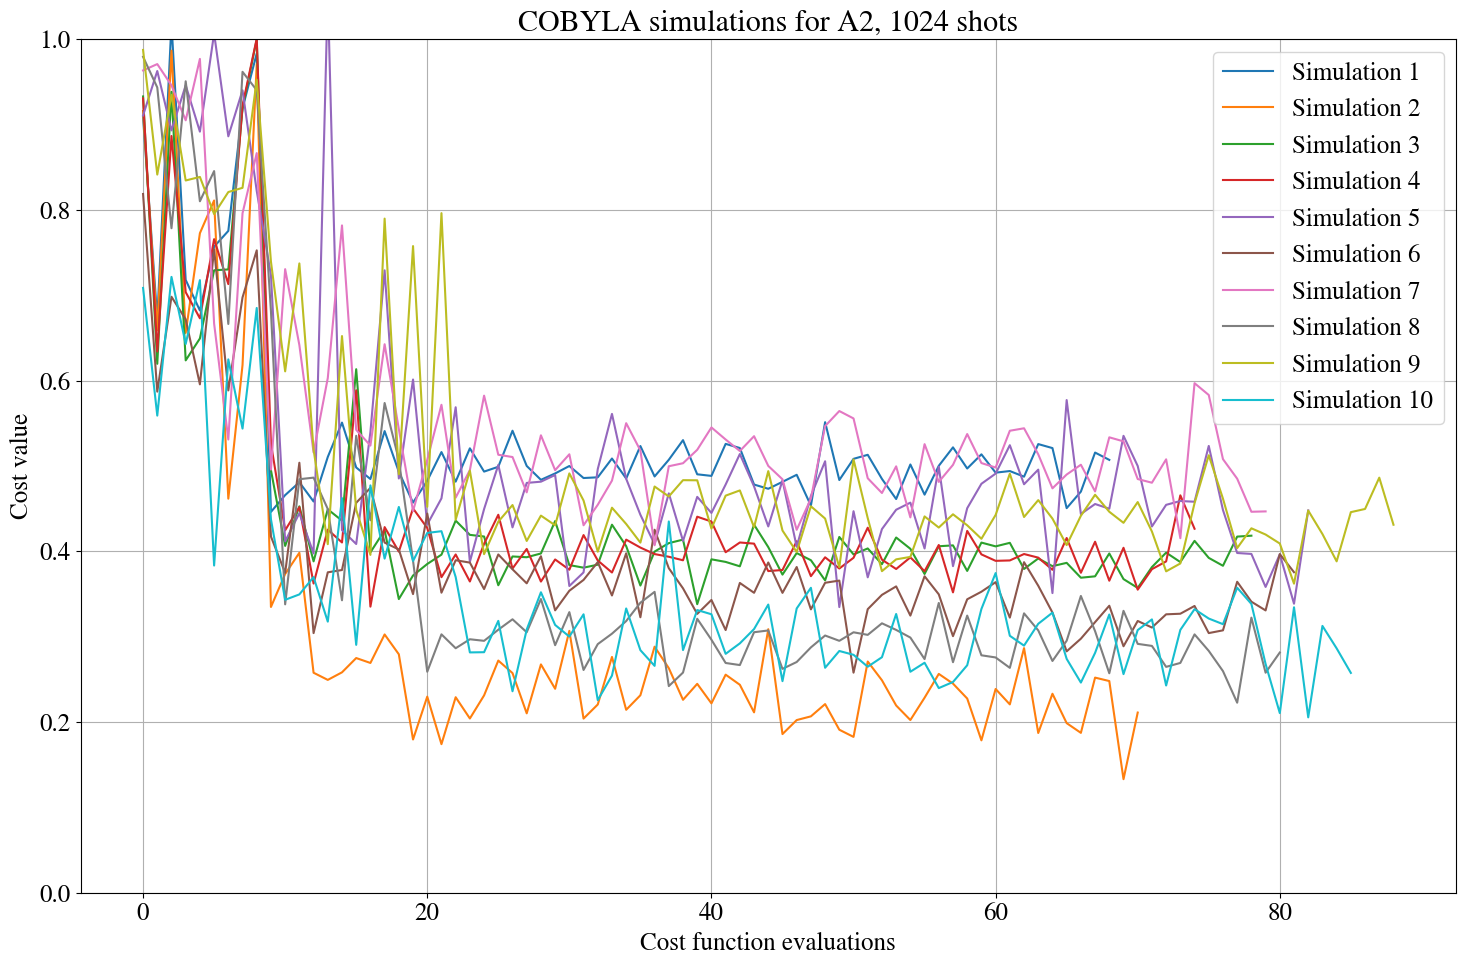

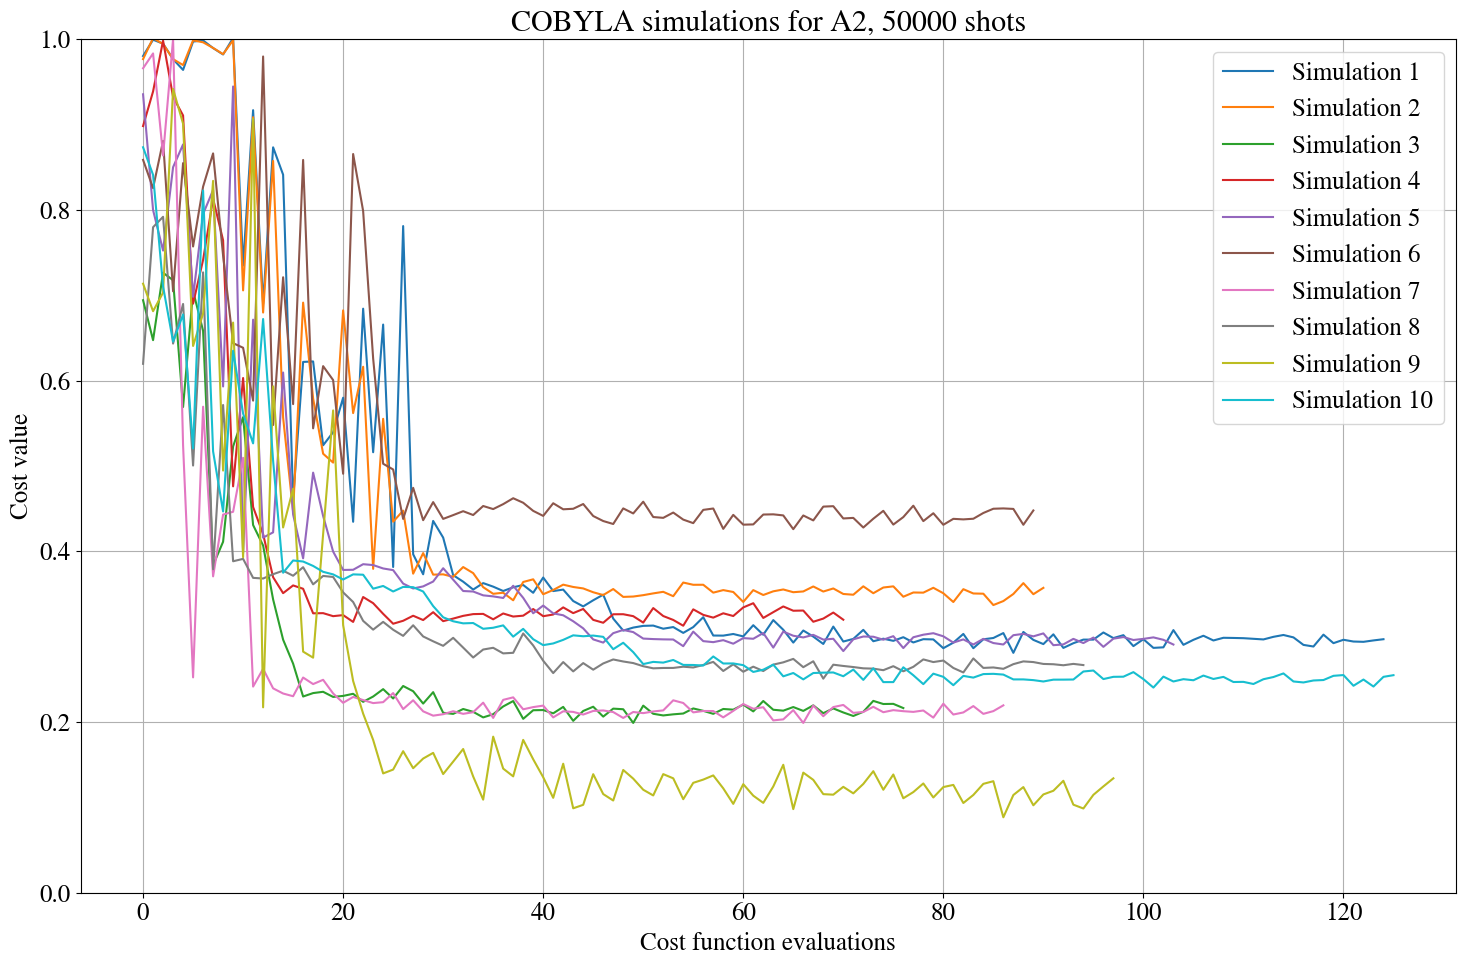

In [ ]:
#Drawing COBYLA minimizing simulations

SHOTS_list = [1024,50000]
for shots in SHOTS_list:
    fig_COBYLA, ax_COBYLA = plt.subplots(figsize=(15,10))
    for i in range(1,11): 
        cost_history = np.loadtxt(f"vqls/COBYLA/cost_history_cobyla_{shots}_{i}.txt",skiprows=10)
        ax_COBYLA.plot(range(len(cost_history)), cost_history, label=f"Simulation {i}")
        ax_COBYLA.grid(True)
        ax_COBYLA.legend()
        ax_COBYLA.set_xlabel("Cost function evaluations"), ax_COBYLA.set_ylabel("Cost value")
        ax_COBYLA.set_ylim(top=1,bottom=0)
        ax_COBYLA.set_title(f"COBYLA simulations for A2, {shots} shots")
        fig_COBYLA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
        fig_COBYLA.savefig(f"vqls/COBYLA/cost_history_COBYLA_{shots}.pdf")

The results are far from ideal. The cost value should go to 0, however the classical optimizer using a linear approximated gradient does not work. This is because the heavy noise caused by the recounting creates false minima in which the algorithm gets stucked.

To overcome this, we proceed with an empirical study by Pellow-Arman et al. where they use different classical minimizers, and the best performing one appears to be the Simultaneous Perturbation Stochastic Approximation (SPSA). We therefore implement it with our cost sampling function.

SPSA has hyperparameters like learning rate,resampling perturbation; which can be tuned in order to improve convergence.\
Therefore we have implemented a variety of different combinations and noted the cost value history for each time the cost sampling function was evaluated. The result is displayed below.



In [ ]:
import os       #to create subfolders for data
os.makedirs("vqls/SPSA/calibrate")
os.makedirs("vqls/SPSA/03_017")


In [ ]:
# # SPSA CALIBRATION: THIS FUNCTION IS MANUALLY CHANGED FOR EACH SIMULATION
#each simulation takes around 45 minutes (for maxiter = num_params*20 and using resampling=1)
from qiskit_algorithms.optimizers import SPSA

coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]
x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
num_params = len(x0)

from matplotlib import rcParams
rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def best_x_callback(nfev, parameters, value, stepsize, accepted):   #SPSA callback
    global lowest_cost_SPSA,best_params_SPSA,cost_history_steps_indices       
    cost_history_steps_indices.append(nfev)
    if 0 < value < lowest_cost_SPSA :               #Conditional update of the best value
        lowest_cost_SPSA = value
        best_params_SPSA = np.copy(parameters)
        print(f"New Best Found: Cost = {value:.6f} at nfev = {nfev}")
        print(f"Parameters: {parameters}")
        
    return best_params_SPSA, lowest_cost_SPSA


SHOTS_list = [50000]
for shots in SHOTS_list:
    # print(f"Shots: {shots}")
    best_params_SPSA = x0
    lowest_cost_SPSA  = 1
    cost_history_cal = []

    #Different options to choose from for each iteration

    # a, c = SPSA.calibrate(      use if we want to automatically calibrate  #
    #     loss=lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2, gate_set_2, cost_history_cal),
    #     initial_point=x0,
    #     target_magnitude=0.2,     
    #     c=0.15
    # )

    #Manual decay function, simulating what SPSA does
    def powerlaw_decay(initial_value, max_iter, power=0.602, stability_constant_ratio=0.1):
        A = max_iter * stability_constant_ratio
        #value_k = a / (k + A)^power
        numerator = initial_value * (A ** power)
        k = 0
        while True:
            yield numerator / ((k + A) ** power)
            k += 1
    def custom_learning_rate_schedule():
        # Standard SPSA power for the learning_rate a is 0.602.
        return powerlaw_decay(initial_value=0.35, max_iter=num_params*20, power=0.632, stability_constant_ratio=0.1)
    def custom_perturbation_schedule():
        # Standard SPSA power for the perturbation c is 0.101
        return powerlaw_decay(initial_value=0.25, max_iter=num_params*20, power=0.101, stability_constant_ratio=0.1)


    a, c = 0.5, 0.3             # if we want fixed SPSA parameters
    global_i = 83               # CHANGE THIS for every different simulation to calibrate
    spsa = SPSA(
        maxiter=num_params*20,      #lower if we use resamplings > 1
        learning_rate=a,
        perturbation=c,
        blocking=True,
        trust_region=True,
        # allowed_increase=0.01,
        # resamplings=3,
        callback=best_x_callback,
        )

    cost_history_SPSA, cost_history_steps_indices = [], []
    out = spsa.minimize(
        fun=lambda x: calculate_cost_function_sampling(x,shots,coefficient_set_2,gate_set_2,cost_history_SPSA),
        x0=x0)
    # print(out)
    out_f = [out.x[0:3], out.x[3:6], out.x[6:9]]

    # print(f"Best x Found (Tracked by Callback): {best_params_SPSA}")
    # print(f"Best Cost Found (Tracked by Callback): {lowest_cost_SPSA}")

    
    with open(f"vqls/SPSA/calibrate/cost_history_SPSA_{shots}_{global_i}.txt", "w") as f:
        f.write("\n SPSA MINIMIZATION \n")
        f.write(f"a, c = {a}, {c}\n")   #we describe manually the parameters (calibrated or not)
        f.write("shots = " + str(shots) + "\n")
        f.write(str(out)+ "\n \n")
        f.write("\n Best x Found (Tracked by Callback): " + str(best_params_SPSA) + "\n")
        f.write("Lowest Cost Found (Tracked by Callback): " + str(lowest_cost_SPSA) + "\n \n \n \n")
        f.write("\n".join(str(item) for item in cost_history_SPSA))

    with open(f"vqls/SPSA/calibrate/cost_history_steps_{shots}_{global_i}_indices.txt", "w") as f:
        f.write("\n".join(str(item) for item in cost_history_steps_indices))

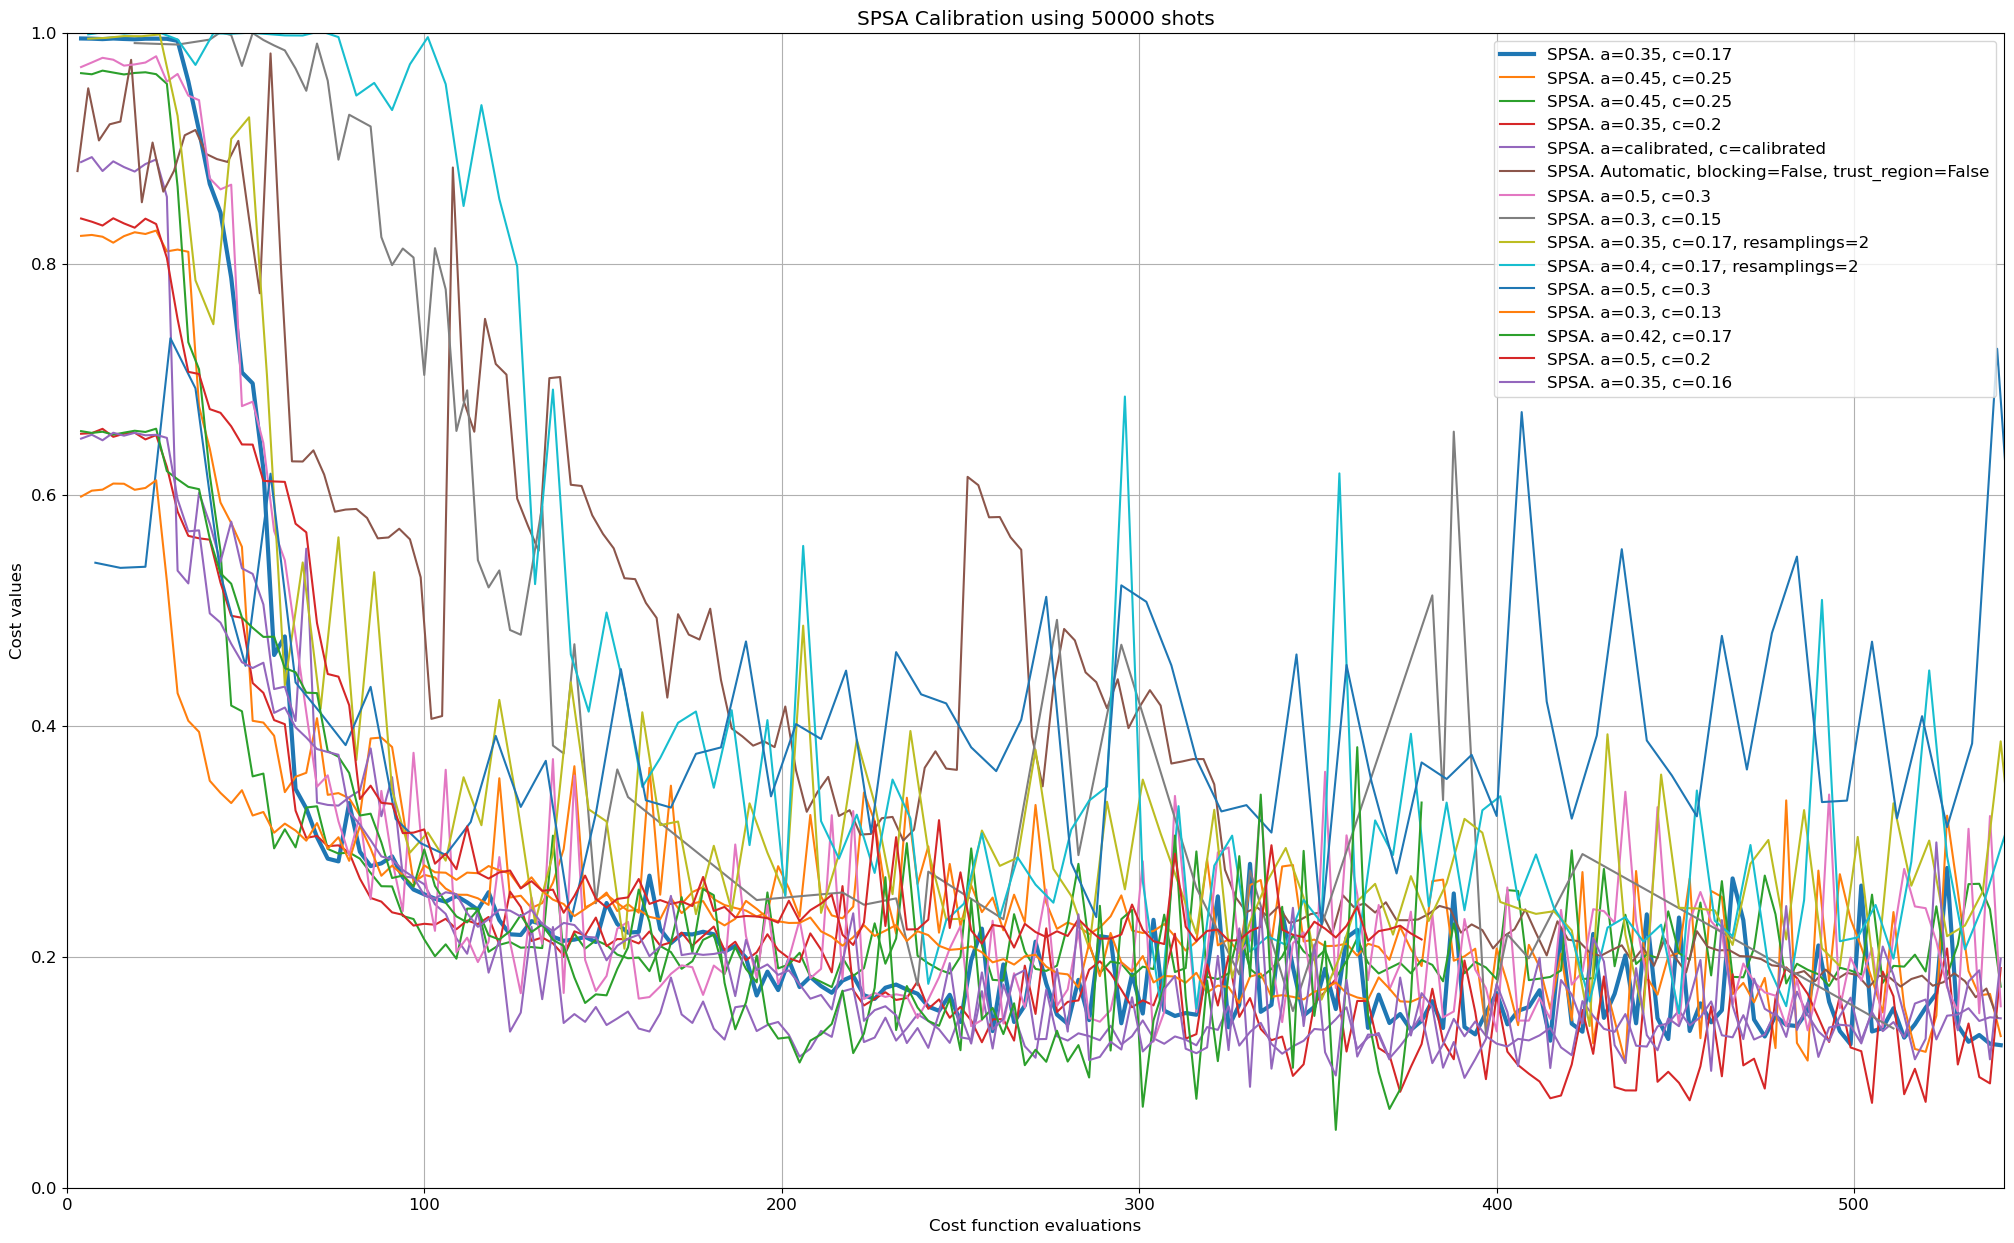

In [ ]:
#CALIBRATION PLOTS

import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'sans', 'text.usetex': False})


cost_values_SPSA_50000_12 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_12.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_13 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_13.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_14 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_14.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_15 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_15.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_16 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_16.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_17 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_17.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_18 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_18.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_19 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_19.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_22 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_22.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_23 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_23.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_25 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_25.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_26 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_26.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_27 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_27.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_28 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_28.txt', skiprows=19, usecols=0)
cost_values_SPSA_50000_29 = np.loadtxt('vqls/SPSA/calibrate/cost_history_SPSA_50000_29.txt', skiprows=19, usecols=0)



iters_12,iters_13,iters_14,iters_15,iters_16,iters_17,iters_18,iters_19,iters_22,iters_23,iters_25,iters_26,iters_27,iters_28,iters_29 = \
len(cost_values_SPSA_50000_12),len(cost_values_SPSA_50000_13),len(cost_values_SPSA_50000_14),len(cost_values_SPSA_50000_15),len(cost_values_SPSA_50000_16),len(cost_values_SPSA_50000_17),len(cost_values_SPSA_50000_18),len(cost_values_SPSA_50000_19),len(cost_values_SPSA_50000_22),len(cost_values_SPSA_50000_23),len(cost_values_SPSA_50000_25),len(cost_values_SPSA_50000_26),len(cost_values_SPSA_50000_27),len(cost_values_SPSA_50000_28),len(cost_values_SPSA_50000_29)

plt.figure(figsize=(25,15))

sc12 = plt.scatter(range(1, iters_12+1), cost_values_SPSA_50000_12, alpha=0.000)
sc13 = plt.scatter(range(1, iters_13+1), cost_values_SPSA_50000_13, alpha=0.000)
sc14 = plt.scatter(range(1, iters_14+1), cost_values_SPSA_50000_14, alpha=0.000)
sc15 = plt.scatter(range(1, iters_15+1), cost_values_SPSA_50000_15, alpha=0.000)
sc16 = plt.scatter(range(1, iters_16+1), cost_values_SPSA_50000_16, alpha=0.000)
sc17 = plt.scatter(range(1, iters_17+1), cost_values_SPSA_50000_17, alpha=0.000)
sc18 = plt.scatter(range(1, iters_18+1), cost_values_SPSA_50000_18, alpha=0.000)
sc19 = plt.scatter(range(1, iters_19+1), cost_values_SPSA_50000_19, alpha=0.000)
sc22 = plt.scatter(range(1, iters_22+1), cost_values_SPSA_50000_22, alpha=0.000)
sc23 = plt.scatter(range(1, iters_23+1), cost_values_SPSA_50000_23, alpha=0.000)
sc25 = plt.scatter(range(1, iters_25+1), cost_values_SPSA_50000_25, alpha=0.000)
sc26 = plt.scatter(range(1, iters_26+1), cost_values_SPSA_50000_26, alpha=0.000)
sc27 = plt.scatter(range(1, iters_27+1), cost_values_SPSA_50000_27, alpha=0.000)
sc28 = plt.scatter(range(1, iters_28+1), cost_values_SPSA_50000_28, alpha=0.000)
sc29 = plt.scatter(range(1, iters_29+1), cost_values_SPSA_50000_29, alpha=0.000)


iters_steps_12 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_12_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_13 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_13_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_14 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_14_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_15 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_15_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_16 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_16_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_17 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_17_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_18 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_18_indices.txt', skiprows=0, usecols=0).astype(int)
iters_steps_19 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_19_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_22 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_22_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_23 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_23_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_25 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_25_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_26 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_26_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_27 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_27_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_28 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_28_indices.txt',skiprows=0,usecols=0).astype(int)
iters_steps_29 = np.loadtxt('vqls/SPSA/calibrate/cost_history_steps_50000_29_indices.txt',skiprows=0,usecols=0).astype(int)


cost_values_steps_50000_12 = cost_values_SPSA_50000_12[iters_steps_12]
cost_values_steps_50000_13 = cost_values_SPSA_50000_13[iters_steps_13]
cost_values_steps_50000_14 = cost_values_SPSA_50000_14[iters_steps_14]
cost_values_steps_50000_15 = cost_values_SPSA_50000_15[iters_steps_15]
cost_values_steps_50000_16 = cost_values_SPSA_50000_16[iters_steps_16]
cost_values_steps_50000_17 = cost_values_SPSA_50000_17[iters_steps_17]
cost_values_steps_50000_18 = cost_values_SPSA_50000_18[iters_steps_18]
cost_values_steps_50000_19 = cost_values_SPSA_50000_19[iters_steps_19]
cost_values_steps_50000_22 = cost_values_SPSA_50000_22[iters_steps_22]
cost_values_steps_50000_23 = cost_values_SPSA_50000_23[iters_steps_23]
cost_values_steps_50000_25 = cost_values_SPSA_50000_25[iters_steps_25]
cost_values_steps_50000_26 = cost_values_SPSA_50000_26[iters_steps_26]
cost_values_steps_50000_27 = cost_values_SPSA_50000_27[iters_steps_27]
cost_values_steps_50000_28 = cost_values_SPSA_50000_28[iters_steps_28]
cost_values_steps_50000_29 = cost_values_SPSA_50000_29[iters_steps_29]


plt.plot(iters_steps_12, cost_values_steps_50000_12, color=sc12.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.35, c=0.17", lw=3)
plt.plot(iters_steps_13, cost_values_steps_50000_13, color=sc13.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.45, c=0.25")
plt.plot(iters_steps_14, cost_values_steps_50000_14, color=sc14.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.45, c=0.25")
plt.plot(iters_steps_15, cost_values_steps_50000_15, color=sc15.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.35, c=0.2")
plt.plot(iters_steps_16, cost_values_steps_50000_16, color=sc16.get_facecolor()[0], alpha=1,label=r"SPSA. a=calibrated, c=calibrated")
plt.plot(iters_steps_17, cost_values_steps_50000_17, color=sc17.get_facecolor()[0], alpha=1,label=r"SPSA. Automatic, blocking=False, trust_region=False")
plt.plot(iters_steps_18, cost_values_steps_50000_18, color=sc18.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.5, c=0.3")
plt.plot(iters_steps_19, cost_values_steps_50000_19, color=sc19.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.3, c=0.15")


plt.plot(iters_steps_22, cost_values_steps_50000_22, color=sc22.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.35, c=0.17, resamplings=2")
plt.plot(iters_steps_23, cost_values_steps_50000_23, color=sc23.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.4, c=0.17, resamplings=2")
plt.plot(iters_steps_25, cost_values_steps_50000_25, color=sc25.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.5, c=0.3")
plt.plot(iters_steps_26, cost_values_steps_50000_26, color=sc26.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.3, c=0.13")
plt.plot(iters_steps_27, cost_values_steps_50000_27, color=sc27.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.42, c=0.17")
plt.plot(iters_steps_28, cost_values_steps_50000_28, color=sc28.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.5, c=0.2")
plt.plot(iters_steps_29, cost_values_steps_50000_29, color=sc29.get_facecolor()[0], alpha=1,label=r"SPSA. a=0.35, c=0.16")



plt.xlabel("Cost function evaluations"),plt.ylabel("Cost values")
plt.ylim(bottom=0),plt.xlim(left=0,right=600)
plt.legend(loc=1), plt.grid(True), plt.ylim(top=1), plt.xlim(right=542)
plt.title("SPSA Calibration using 50000 shots")
plt.savefig("vqls/SPSA/calibrate/SPSA_50000_calibrate.pdf")

For the simulations that both 'blocking', 'trust_region' and 'resamplings' are not specified in the legend, they were set to True, True and 1 respectively.


We see that the noise threshold of 0.2 is almost always surpassed, although it takes in general more than 200 function evaluations. This is problematic, because the computational time in our computers to evaluate 200 evaluations is around 15 minutes.



We now choose the parameters a = 0.35, b = 0.17, 'blocking' = 'trust_region' True and 'resamplings' = 1. The reason behind is an overall good performance, usually getting below the noise threshold before 100 iterations.  It is represented in the previous graph with thicker line width.

We will do 10 simulations for 1024 circuit shots, and another 10 for 50000 circuit shots.


In [ ]:
# # OPTIMIZED SPSA SIMULATIONS with a=0.35 and b=0.17
from qiskit_algorithms.optimizers import SPSA

coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]


from matplotlib import rcParams
rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def best_x_callback(nfev, parameters, value, stepsize, accepted):   #SPSA callback
    global lowest_cost_SPSA,best_params_SPSA,cost_history_steps_indices       
    cost_history_steps_indices.append(nfev)
    if 0 < value < lowest_cost_SPSA :               #Conditional update of the best value
        lowest_cost_SPSA = value
        best_params_SPSA = np.copy(parameters)
        print(f"New Best Found: Cost = {value:.6f} at nfev = {nfev}")
        print(f"Parameters: {parameters}")
        
    return best_params_SPSA, lowest_cost_SPSA


SHOTS_list = [1024, 50000]
for shots in SHOTS_list:
    for i in range(50,60): 
        # print(f"Shots: {shots}")
        x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
        num_params = len(x0)
        best_params_SPSA = x0
        lowest_cost_SPSA  = 1
        
        a, c = 0.35, 0.17             
        spsa = SPSA(
            maxiter=num_params*20,      
            learning_rate=a,
            perturbation=c,
            blocking=True,
            trust_region=True,
            callback=best_x_callback,
            )

        cost_history_SPSA, cost_history_steps_indices = [], []
        out = spsa.minimize(
            fun=lambda x: calculate_cost_function_sampling(x,shots,coefficient_set_2,gate_set_2,cost_history_SPSA),
            x0=x0)
        # print(out)
        out_f = [out.x[0:3], out.x[3:6], out.x[6:9]]

        # print(f"Best x Found (Tracked by Callback): {best_params_SPSA}")
        # print(f"Best Cost Found (Tracked by Callback): {lowest_cost_SPSA}")

        
        with open(f"vqls/SPSA/035_017/cost_history_035_017_SPSA_{shots}_{i}.txt", "w") as f:
            f.write("\n SPSA MINIMIZATION \n")
            f.write(f"a, c = {a}, {c}\n")   
            f.write("shots = " + str(shots) + "\n")
            f.write(str(out)+ "\n \n")
            f.write("\n Best x Found (Tracked by Callback): " + str(best_params_SPSA) + "\n")
            f.write("Lowest Cost Found (Tracked by Callback): " + str(lowest_cost_SPSA) + "\n \n \n \n")
            f.write("\n".join(str(item) for item in cost_history_SPSA))

        with open(f"vqls/SPSA/035_017/cost_history_035_017_steps_{shots}_{i}_indices.txt", "w") as f:
            f.write("\n".join(str(item) for item in cost_history_steps_indices))

New Best Found: Cost = 0.892304 at nfev = 4
Parameters: [1.97299173 0.58678013 5.88267657 4.52855202 4.39206218 0.85388445
 4.08383034 1.09553209 2.39888528]
New Best Found: Cost = 0.889372 at nfev = 7
Parameters: [1.96244421 0.59732765 5.89322409 4.53909953 4.4026097  0.86443196
 4.07328282 1.10607961 2.38833776]
New Best Found: Cost = 0.835459 at nfev = 10
Parameters: [1.84577754 0.71399432 5.77655742 4.6557662  4.51927637 0.98109863
 3.95661616 1.22274627 2.50500443]
New Best Found: Cost = 0.763060 at nfev = 13
Parameters: [1.72911088 0.59732765 5.65989075 4.53909953 4.63594303 1.0977653
 3.83994949 1.33941294 2.62167109]
New Best Found: Cost = 0.689648 at nfev = 16
Parameters: [1.61244421 0.71399432 5.54322409 4.6557662  4.51927637 1.21443196
 3.72328282 1.22274627 2.73833776]
New Best Found: Cost = 0.685156 at nfev = 19
Parameters: [1.58348193 0.7429566  5.57218637 4.62680392 4.54823865 1.18546968
 3.69432054 1.25170856 2.76730004]
New Best Found: Cost = 0.683574 at nfev = 22
Para

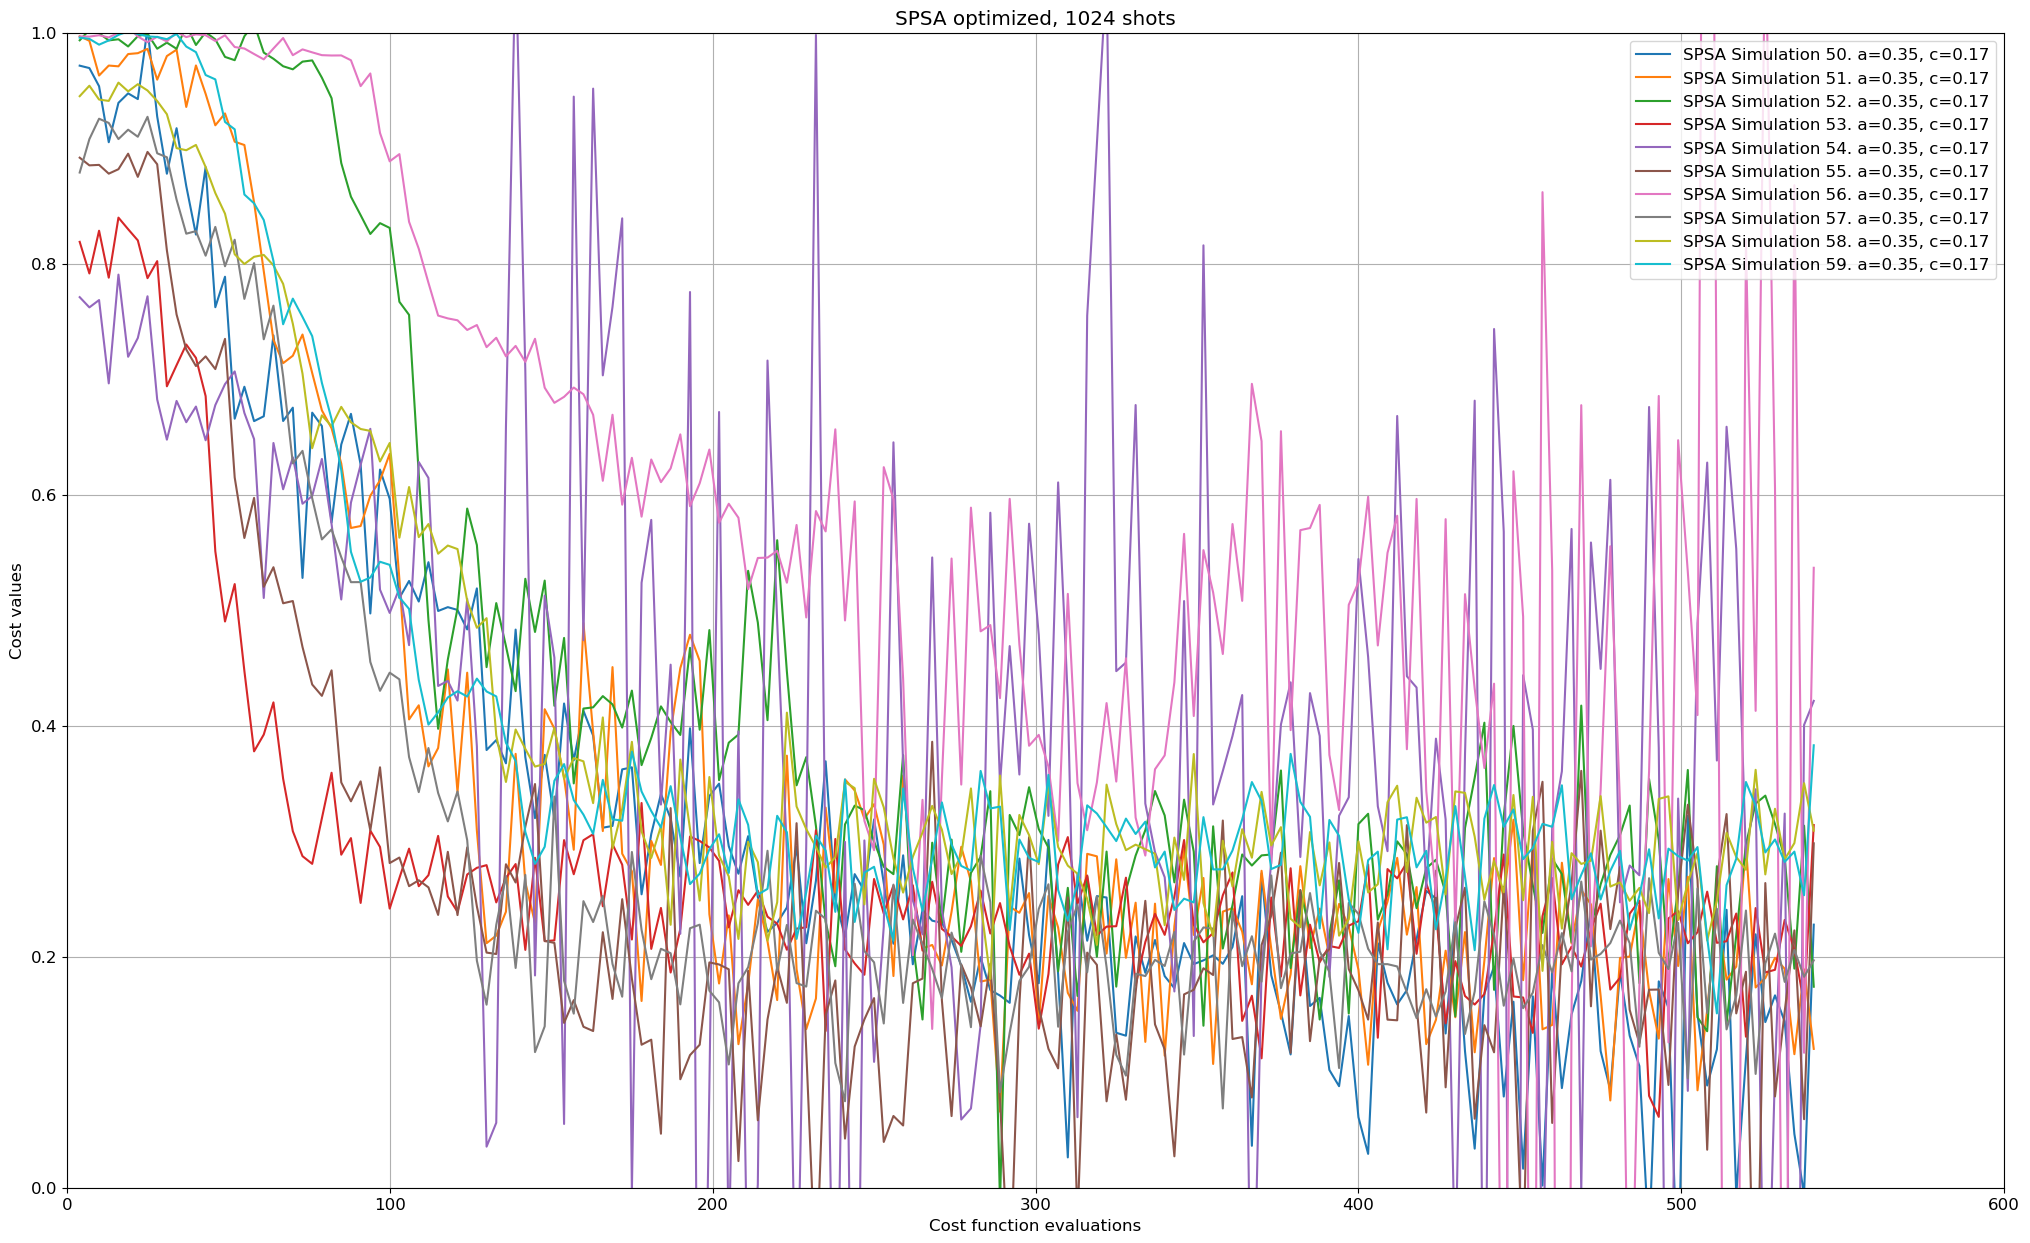

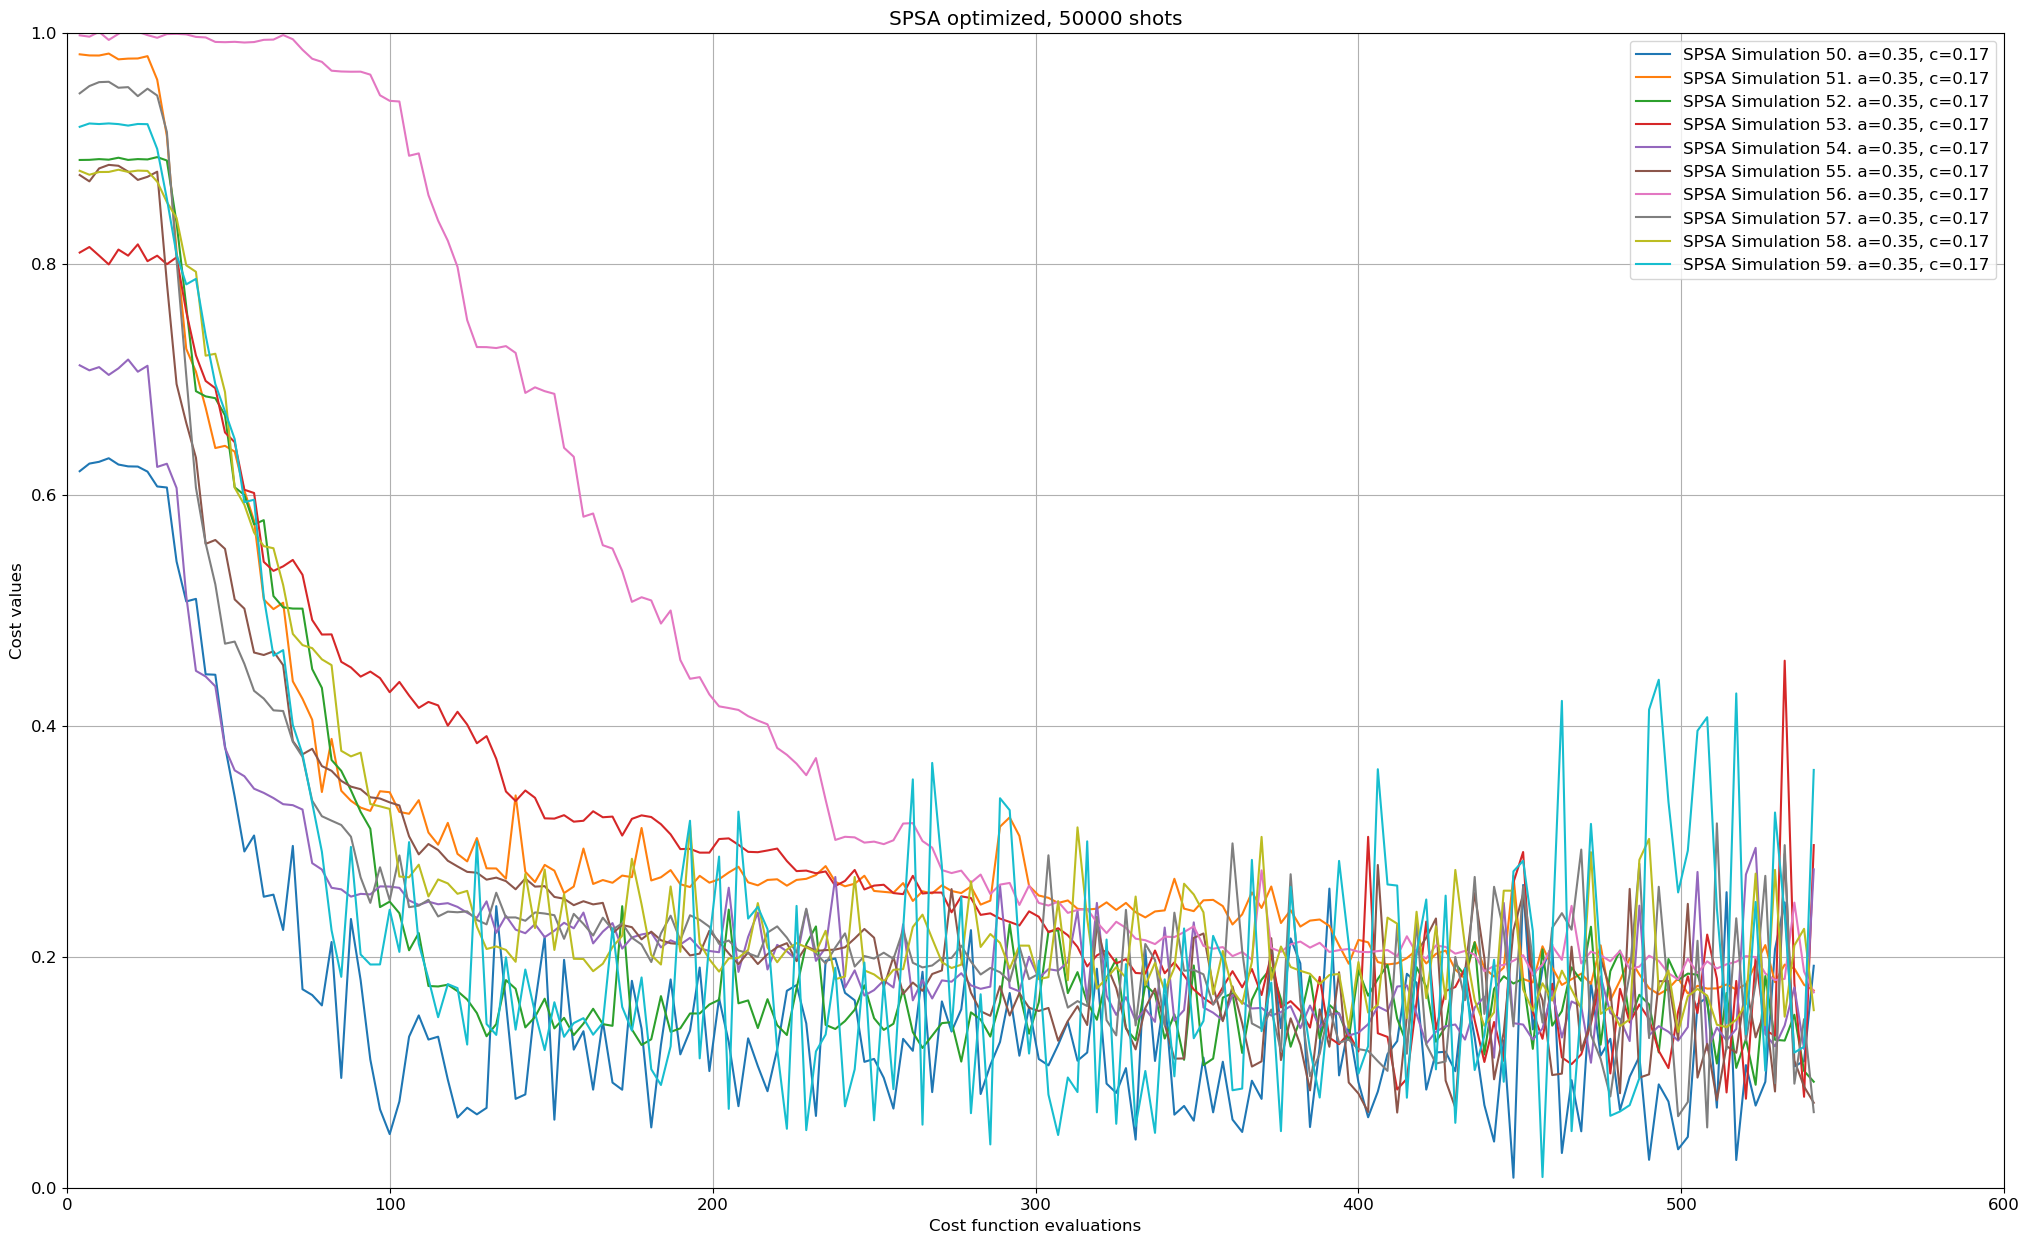

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'sans', 'text.usetex': False})

SHOTS_list = [1024,50000]
for shots in SHOTS_list:
    plt.figure(figsize=(25,15))
    for i in range(50,60):
        cost_values_SPSA = np.loadtxt(f'vqls/SPSA/035_017/cost_history_035_017_SPSA_{shots}_{i}.txt', skiprows=19, usecols=0)

        iters = len(cost_values_SPSA)

        

        sc = plt.scatter(range(1, iters+1), cost_values_SPSA, alpha=0.000)

        iters_steps = np.loadtxt(f'vqls/SPSA/035_017/cost_history_035_017_steps_{shots}_{i}_indices.txt', skiprows=0, usecols=0).astype(int)

        cost_values_steps_50000 = cost_values_SPSA[iters_steps]

        plt.plot(iters_steps, cost_values_steps_50000, color=sc.get_facecolor()[0], alpha=1,label=rf"SPSA Simulation {i}. a=0.35, c=0.17")


    plt.xlabel("Cost function evaluations"),plt.ylabel("Cost values")
    plt.ylim(bottom=0),plt.xlim(left=0,right=600)
    plt.legend(loc=1), plt.grid(True), plt.ylim(top=1)
    plt.title(f"SPSA optimized, {shots} shots")
    plt.savefig(f"vqls/SPSA/035_017/SPSA_{shots}.pdf")

The results for 1024 shots are very noisy, we see that the SPSA minimizer jumps across a lot of different values. However it is capable to reach lower cost values than the COBYLA minimizer.

For 50000 shots the results are excellent, all simulations were capable of crossing the 0.2 threshold, meanwhile the COBYLA minimizer did that only in one of them.

We now select the best parameters obtained by minimizing the cost sampling function via SPSA, which from the previous work come from simulation 50 (with 50000 shots) with a lowest cost of 0.00865716923621751 . This result is remarkably accurate.

In [18]:
best_params_50000 = [0.38447463, 6.04204463, 3.11599216, 3.12614313, 1.75093729, 3.73990698, 4.72659311, 4.33733183, 0.10648397]

comparison_A2(best_params_50000)

|psi_o>: Statevector([ 0.77707872+0.j,  0.51779173+0.j, -0.14902688+0.j,
             -0.15915525+0.j,  0.05531966+0.j,  0.07460806+0.j,
              0.14423611+0.j,  0.22598741+0.j],
            dims=(2, 2, 2))
A2*|psi_o> / norm(A2*|psi_o>): [0.30582869+0.j 0.20378317+0.j 0.41055926+0.j 0.43846226+0.j
 0.28303233+0.j 0.38171772+0.j 0.28382929+0.j 0.44470034+0.j]
|b> : [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339] 

Overlap: (0.9466281856329517+0j) 

quantum solution x:  Statevector([ 3.14331938+0.j,  2.0944915 +0.j, -0.60282061+0.j,
             -0.64379034+0.j,  0.22377058+0.j,  0.30179306+0.j,
              0.58344174+0.j,  0.91412953+0.j],
            dims=(2, 2, 2))
real solution x:  [ 3.53553391  3.53553391 -0.50507627 -0.50507627  0.27196415  0.27196415
  0.70710678  0.70710678]


The check is satisfactory, however the innate noise of the sampling process gives a lower overlap (~0.95) than expected (~0.992). The quantum solution is accurate, but not as much as the previous case using the statevector simulations.

For completeness, we include the best parameters obtained with the very noisy 1024 shots simulations, corresponding to simulation 50. The final cost value was 0.0018924245886655644, again remarkably low; but possibly accidental due to sampling error. 

In [21]:
best_params_1024 = [ 0.05709841,  1.00131499, -1.21069665,  0.24340689,  3.2523091,   3.29927728, 1.38876966,  3.31534636,  2.62047951]

comparison_A2(best_params_1024)

|psi_o>: Statevector([-0.71009462+0.j, -0.46059884+0.j,  0.25946624+0.j,
              0.15606736+0.j, -0.1084577 +0.j, -0.16831676+0.j,
             -0.27791848+0.j, -0.27313421+0.j],
            dims=(2, 2, 2))
A2*|psi_o> / norm(A2*|psi_o>): [-0.17875382+0.j -0.11594765+0.j -0.45721241+0.j -0.27501048+0.j
 -0.35493011+0.j -0.55082016+0.j -0.34980543+0.j -0.34378365+0.j]
|b> : [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339] 

Overlap: (0.8621576279938762-0j) 

quantum solution x:  Statevector([ 1.92513857+0.j,  1.24873018+0.j, -0.70343931-0.j,
             -0.42311446-0.j,  0.29403982+0.j,  0.45632382+0.j,
              0.7534652 +0.j,  0.74049456+0.j],
            dims=(2, 2, 2))
real solution x:  [ 3.53553391  3.53553391 -0.50507627 -0.50507627  0.27196415  0.27196415
  0.70710678  0.70710678]


Indeed we see that the ~0.86 overlap should be way higher given our cost value ~0.002; nonetheless it corresponds to a "real" cost function of ~0.14, which is again lower than the one achieved using the COBYLA minimizer.

In [ ]:
%reset -f   #we reset again before the last part

# References

The first implementation of a variational quantum eigensolver comes from the paper "A variational eigenvalue solver on a photonic quantum processor" by Peruzzo et al., available in [Nature](https://doi.org/10.1038/ncomms5213)

The utilization of VQLS was taken from the paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto et al., published at [Quantum](https://doi.org/10.22331/q-2023-11-22-1188).

The different minimization approaches were utilized by Pellow-Arman et al. in "A Comparison of Various Classical Optimizers for a Variational Quantum Linear Solver", published at [Springer](https://doi.org/10.1007/s11128-021-03140-x).


